In [1]:
import os
import sep
import glob
import fitsio
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Ellipse

from PyAstronomy import pyasl
from scipy.interpolate import interp1d

from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as c
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.wcs as AsWCS
from mpdaf.obj import WCS
import scipy.integrate
from astropy.cosmology import FlatLambdaCDM
import requests
from PIL import Image
from io import BytesIO

import hostphot
from hostphot._constants import workdir
from hostphot._constants import font_family
from hostphot.cutouts import download_images
from hostphot.cutouts import check_existing_images
from hostphot.coadd import coadd_images
from hostphot.image_cleaning import remove_nan
from hostphot.image_masking import create_mask
from hostphot.utils import plot_fits, get_survey_filters
from hostphot.sed_plotting import plot_sed
import hostphot.local_photometry as lp
import hostphot.global_photometry as gp


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Fontconfig warning: ignoring UTF-8: not a valid region tag
/Users/dingyuancao/opt/anaconda3/envs/Hostphot/lib/python3.11/site-packages/hostphot/utils.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  config_df = pd.read_csv(config_file, delim_whitespace=True)
/Users/dingyuancao/opt/anaconda3/envs/Hostphot/lib/python3.11/site-packages/hostphot/sed_plotting.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  config_df = pd.read_csv(config_file, delim_whitespace=True)


In [2]:
print('HostPhot version:', hostphot.__file__)

HostPhot version: /Users/dingyuancao/opt/anaconda3/envs/Hostphot/lib/python3.11/site-packages/hostphot/__init__.py


## Check if targets are in PS1

In [106]:
def getimages(ra,dec,filters="grizy"):
    
    """Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = f"{service}?ra={ra}&dec={dec}&filters={filters}"
    table = Table.read(url, format='ascii')
    return table

In [107]:
FN_samples = pd.read_csv('Foundation_samples.csv')
allnames = list(FN_samples['CID'])
allredshifts = list(FN_samples['zHD'])
allhost_ras = list(FN_samples['RA'])
allhost_decs = list(FN_samples['DEC'])

targets_in_PS1 = []
for n in range(0,len(allnames)):
    try:
        getimages(allhost_ras[n],allhost_decs[n],filters="grizy")
        targets_in_PS1.append(allnames[n])
    except:
        print('Target not in PS1')
        continue

Target not in PS1


## Filter the targets that are ONLY in PS1

In [3]:
FN_samples_host = pd.read_csv('Foundation_samples_host_info.csv') # original Foundation sample
FN_checking = pd.read_csv('FN_checking.csv') # [not needed for distance]
FN_No_SDSS = FN_checking[FN_checking['Mass'] == 'N']['CID'] # FN that are NOT in SDSS
FN_SDSS = FN_checking[FN_checking['Mass'] != 'N']['CID'] # FN that are in SDSS

# Extract all FN targets with only PS1 images
FN_PS1_ONLY = FN_samples_host[FN_samples_host['CID'].isin(FN_No_SDSS)] #63
#FN_PS1_ONLY.to_csv('FN_PS1_ONLY.csv', index=False)

# Extract all FN targets with both PS1 and SDSS images
FN_PS1_SDSS = FN_samples_host[FN_samples_host['CID'].isin(FN_SDSS)] #116
FN_PS1_SDSS.to_csv('FN_PS1_SDSS.csv', index=False)

## Extract host galaxy RA and DEC

In [101]:
FN_samples_host = pd.read_csv('FN_samples_host_info.csv')
All_data = pd.read_csv('all_redshifts_PVs.csv') # all data file adopted from Pantheon analysis data release
FN_samples = pd.read_csv('Foundation_samples.csv')
# Extract all Foundation targets from the all data file
ALL_data_FN = All_data[All_data['SNID'].isin(FN_samples['CID'])]
ALL_data_FN.to_csv('ALL_data_FN.csv', index=False)

# Reorder the ALL_data_FN to match the FN_samples
ALL_data_FN.rename(columns={'SNID':'CID'}, inplace=True) # rename the column 'SNID' 
ALL_data_FN['CID'] = pd.Categorical(ALL_data_FN['CID'], categories=FN_samples['CID'])
ALL_data_FN_reorder = ALL_data_FN.sort_values('CID')

# Replace the host RA and DEC  in the FN_samples with the extracted data
# NOTE: The target SN2016coj is not in the ALL_data_FN file
# FN_samples['HOST_RA'][1:] = ALL_data_FN_reorder['RA_host']
# FN_samples['HOST_DEC'][1:] = ALL_data_FN_reorder['Dec_host']

/var/folders/x2/6fv_ssn576dcwskmwrtlfbhr0000gn/T/ipykernel_22848/956708454.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ALL_data_FN.rename(columns={'SNID':'CID'}, inplace=True) # rename the column 'SNID'
/var/folders/x2/6fv_ssn576dcwskmwrtlfbhr0000gn/T/ipykernel_22848/956708454.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ALL_data_FN['CID'] = pd.Categorical(ALL_data_FN['CID'], categories=FN_samples['CID'])


In [30]:
ALL_data_FN_reorder.to_csv('ALL_data_FN_reorder.csv', index=False)

## Calculate the angular separation between the host galaxy and the supernova

$\theta = Dec$, $\phi = RA$,  $\alpha$ = angular separation

$$ \cos{\alpha} = \sin(\theta_{1})\sin(\theta_{2})+ \cos(\theta_{1})\cos(\theta_{2})\cos(\phi_{1}-\phi_{2}) $$

In [188]:
# Extract RA and DEC of both the host and the SN for all FN targets except SN2016coj
# host_ra = (np.array(FN_samples['HOST_RA'])*u.deg).to(u.rad)[1:]
# host_dec = (np.array(FN_samples['HOST_DEC'])*u.deg).to(u.rad)[1:]
# SN_ra = (np.array(FN_samples['RA'])*u.deg).to(u.rad)[1:]
# SN_dec = (np.array(FN_samples['DEC'])*u.deg).to(u.rad)[1:]

host_ra = (np.array(FN_samples_host['HOST_RA'])*u.deg).to(u.rad)[1:]
host_dec = (np.array(FN_samples_host['HOST_DEC'])*u.deg).to(u.rad)[1:]
SN_ra = (np.array(FN_samples_host['RA'])*u.deg).to(u.rad)[1:]
SN_dec = (np.array(FN_samples_host['DEC'])*u.deg).to(u.rad)[1:]

In [189]:
# Original formula
cos_angsep = np.sin(host_dec)*np.sin(SN_dec) + np.cos(host_dec)*np.cos(SN_dec)*np.cos(host_ra - SN_ra)
angsep = np.arccos(cos_angsep).to(u.arcsec)
angsep = np.array(angsep)

# Small angle approximation
angsep_small = np.sqrt(((host_ra - SN_ra)*np.cos(host_dec))**2 + (host_dec - SN_dec)**2).to(u.arcsec)

In [59]:
FN_samples_host['RA'][63], FN_samples_host['DEC'][63]

(43.1946, 46.9464)

In [40]:
host_ra[63], host_dec[63], SN_ra[63], SN_dec[63]

(<Quantity 0.73814104 rad>,
 <Quantity 0.25483504 rad>,
 <Quantity 0.73815559 rad>,
 <Quantity 0.25483203 rad>)

In [61]:
host_raa = (np.array(FN_samples_host['HOST_RA'])*u.deg).to(u.rad)[63]
host_deca = (np.array(FN_samples_host['HOST_DEC'])*u.deg).to(u.rad)[63]
SN_raa = (np.array(FN_samples_host['RA'])*u.deg).to(u.rad)[63]
SN_deca = (np.array(FN_samples_host['DEC'])*u.deg).to(u.rad)[63]

In [62]:
cos_angsepa = np.sin(host_deca)*np.sin(SN_deca) + np.cos(host_deca)*np.cos(SN_deca)*np.cos(host_raa - SN_raa)
angsepa = np.arccos(cos_angsepa).to(u.arcsec)
angsepa

<Quantity 37.82573572 arcsec>

In [47]:
angsep

array([6.44135009e+01, 7.31238355e+01, 4.84895335e+01, 1.50374033e+00,
       7.71857386e+01, 5.29544952e+01, 6.91245742e+00, 1.01219010e+01,
       3.21069621e+00, 1.38261366e+01, 5.67008733e+00, 1.40351279e+01,
       2.97360426e-01, 4.97776387e+00, 1.14897215e+01, 3.98204157e+00,
       6.02728398e-01, 7.49528583e+01, 2.38903095e+01, 1.36349447e+00,
       3.20794543e+00, 2.04697308e+00, 2.48808567e-01, 1.50325514e+01,
       1.59971009e+01, 1.90553523e+01, 9.64204181e+00, 2.50002663e+00,
       1.39904409e+01, 1.23030330e+01, 1.11395736e+01, 1.35378080e+00,
       6.96501788e+00, 4.09178805e+00, 7.29275224e+00, 2.52593116e+01,
       3.03876726e+01, 1.50577442e+00, 2.53578969e+00, 3.57761876e+00,
       4.70514486e+00, 1.02767110e+01, 7.79758309e-01, 1.02384991e+00,
       1.71765535e+02, 1.14496826e+01,            nan, 9.04693740e+00,
                  nan, 1.96977131e+01, 3.14161298e+00, 6.55283592e+00,
       1.10270781e+01, 5.79091008e+00, 4.53991309e+00, 1.21166764e+01,
      

In [13]:
type(FN_samples_host)

pandas.core.frame.DataFrame

Write the Host angular separation to the Foundation samples csv

In [ ]:
FN_samples_host.replace(list(FN_samples_host['HOST_ANGSEP'][1:]),list(angsep))

In [17]:
FN_samples_host['HOST_ANGSEP'][1:]=list(angsep)

/var/folders/x2/6fv_ssn576dcwskmwrtlfbhr0000gn/T/ipykernel_34866/854881299.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FN_samples_host['HOST_ANGSEP'][1:]=list(angsep)


In [21]:
FN_samples_host.to_csv('FN_samples_host.csv', index=True)

## Calculate the distance from the host galaxy to the supernova

### Method 1: Using the luminosity distance

$$\mu = 5\log_{10} \bigl(\frac{d_{L}}{10\text{pc}} \bigl)+25 $$

In [59]:
# Luminosity distance
dist_modu = FN_samples['MU_SH0ES'] 
D_L = np.array((10**(dist_modu/5))*10) # in unite of pc

# Calculate the Angular diameter distance
redshift = FN_samples['zHD'][1:]
D_A = np.array(D_L[1:] / (1 + redshift)**2) # in unite of pc [Eq21 in (Hogg, 2000)]

# Calculate the physical distance between SN and Host galaxy
dist_SN_host1 = ((D_A*angsep)*u.AU).to(u.kpc)

In [18]:
# Get the indices of nan elements in dist_SN_host1
nan_indices1 = np.where(np.isnan(dist_SN_host1))[0]

# Get the corresponding CID values from FN_samples
cids1 = FN_samples.loc[nan_indices1+1, 'CID']

# Remove the nan values from dist_SN_host2
dist_SN_host1_rm_nan = dist_SN_host1[~np.isnan(dist_SN_host1)]

# Return the indices and CID values of the nan elements
# NOTE: The indices in result1 are the original indices in FN_samples. 
# In dist_SN_host1, the indices are shifted by 1 to match the original index in FN_samples
# e.g. if the original index in FN_samples is 47, the index in dist_SN_host1 is 46
result1 = list(zip(nan_indices1+1, cids1))


### Method 2: Using the cosmological parameters

In [ ]:
# Set cosmological parameters [FlatLambdaCDM: Omk = 0]
H0 = 73.04 # km/s/Mpc [Eq10 Riess2022] 
Om0 = 0.326 # [Pg12 Brout2022] 

# Calsulate co-moving distance and angular diameter distance
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
D_comov = np.array((cosmo.comoving_distance(redshift)).to(u.pc)) # pc
D_A_cosmo = np.array(D_comov * (1 + redshift)) # pc [Eq18 in (Hogg, 2000)]

# Calculate the physical distance between SN and Host galaxy
dist_SN_host2 = ((D_A_cosmo*angsep)*u.AU).to(u.kpc)


In [20]:
# Get the indices of nan elements in dist_SN_host2
nan_indices2 = np.where(np.isnan(dist_SN_host2))[0]

# Get the corresponding CID values from FN_samples
cids2 = FN_samples.loc[nan_indices2+1, 'CID']

# Remove the nan values from dist_SN_host2
dist_SN_host2_rm_nan = dist_SN_host2[~np.isnan(dist_SN_host2)]

# Return the indices and CID values of the nan elements
result2 = list(zip(nan_indices2+1, cids2))


In [24]:
# Check and print the name for which 'has_host' == 0 in ALL_data_FN
has_host_0 = ALL_data_FN.loc[ALL_data_FN['has_host'] == 0, 'CID']
has_host_0

1272    ATLAS16agv
1289     CSS160129
1293     Gaia16agf
1308       PS15asb
1310       PS15bbn
1312       PS15bif
1317       PS15bwh
1335       PS16ccn
Name: CID, dtype: category
Categories (179, object): ['SN2016coj' < '2018gv' < '2019np' < '2017erp' ... 'PS15bzz' < 'SN2016glp' < 'SN2016grz' < 'iPTF17dz']

In [ ]:
min(dist_SN_host1_rm_nan), min(dist_SN_host2_rm_nan), max(dist_SN_host1_rm_nan), max(dist_SN_host2_rm_nan)

(<Quantity 0.08984046 kpc>,
 <Quantity 0.09230032 kpc>,
 <Quantity 82.24036479 kpc>,
 <Quantity 84.53247182 kpc>)

In [ ]:
from scipy.stats import ks_2samp
ks_2samp(dist_SN_host1_rm_nan, dist_SN_host2_rm_nan)

KstestResult(statistic=0.052941176470588235, pvalue=0.9717900532247673, statistic_location=441854275.76056504, statistic_sign=1)

## Calculate the directional light radius (DLR) -- Need photometry info from Hostphot

[Sullivan+ 2006](https://arxiv.org/abs/astro-ph/0605455)
[Smith+ 2012](https://arxiv.org/abs/1208.2100)
[Gupta+ 2016](https://arxiv.org/abs/1603.04476)
[Sako+ 2018](https://arxiv.org/abs/1801.07274)
[Smith+ 2020](https://doi.org/10.1093/mnras/staa946)
[Sako+ 2024](https://arxiv.org/abs/2401.07274)

### Extract Ellipse shape parameters

In [818]:
# Grab all PS1_riz files from Foundation Samples
surveys = 'PS1_riz.fits'
FN_samples = pd.read_csv('FN_samples_host_info.csv')
names = FN_samples['CID']
csv_files = []
for name in names:
    survey_files = os.listdir(f'images/{name}')
    for file in survey_files:
        if file == surveys:
            csv_files.append(f'images/{name}/' + file)

In [22]:
data = fitsio.read(csv_files[29]) # Define getObj function to extract objects from the image 

#bkg = sep.Background(data, mask=mask, bw=64, bh=64, fw=3, fh=3)

def getObj(data):
    coefficient = 50
    acc = 1
    exp = 1
    objects = sep.extract(data, 1100, err=1,minarea=coefficient)
    objLen = objects.shape[0]
    while objLen != 1:
        if (objLen > 1):
            if (len(str(int(coefficient/(10**exp)))) == acc):
                coefficient += 1 * 10**exp
            else: 
                exp += 1
                coefficient = 2 * 10**exp
            objects = sep.extract(data, 1100, err=1,minarea=coefficient)
            objLen = objects.shape[0] 
        else:
            coefficient -= 1 * 10**exp
            acc += 1
            exp -= 1
            coefficient += 1 * 10**exp
            objects = sep.extract(data, 1100, err=1,minarea=coefficient)
            objLen = objects.shape[0] 
                        
    print(objLen)
    objects = pd.DataFrame(objects)
    return objects
objects = getObj(data)
#objects['a'][0], objects['b'][0], objects['theta'][0], objects['x'][0], objects['y'][0]

1


In [1]:
objects

NameError: name 'objects' is not defined

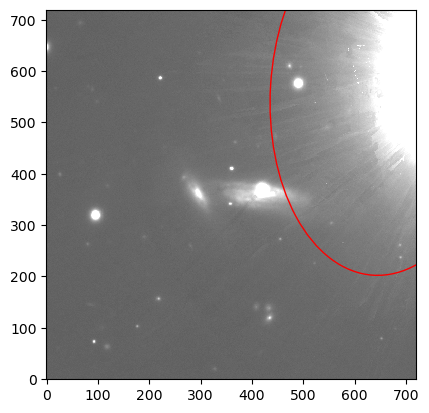

In [24]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data), np.std(data)
im = ax.imshow(data, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [281]:
csv_files[8]

'images/ASASSN-16dn/PS1_riz.fits'

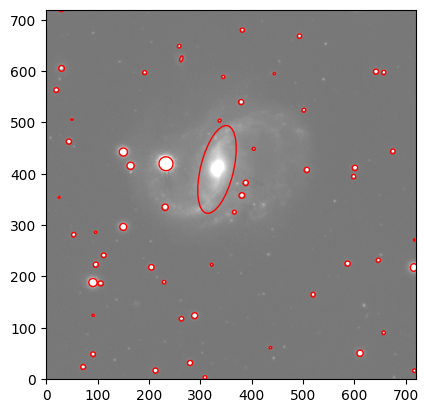

In [279]:
data8 = fitsio.read(csv_files[10])
obj8 = sep.extract(data8, 5000)
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data8), np.std(data8)
im = ax.imshow(data8, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(obj8)):
    e = Ellipse(xy=(obj8['x'][i], obj8['y'][i]),
                width=6*obj8['a'][i],
                height=6*obj8['b'][i],
                angle=obj8['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [ ]:
# Append all a,b,theta into lists
a_list = []
b_list = []
theta_list = []
    #print(n)
for n in range(0, len(csv_files)):
    data = fitsio.read(csv_files[n])
    obj = getObj(data)

    a_list.append(obj['a'][0])
    b_list.append(obj['b'][0])
    theta_list.append(obj['theta'][0])

### Calculate the DLR

$$ \cos{\alpha} = \sin(\text{dec}_{1})\sin(\text{dec}_{2})+ \cos(\text{dec}_{1})\cos(\text{dec}_{2})\cos(\text{ra}_{1}-\text{ra}_{2}) $$
$\alpha$ is angular separation

$$DLR = \frac{ab}{\sqrt{(a\sin{\theta})^{2} + (b\cos{\theta})^{2}}} $$
$a$ = major axis, $b$ = minor axis, $\theta$ = position angle

$$d_{DLR} = \frac{\alpha}{DLR} $$

In [59]:
# Reorder the FN_shape and drop NA from FN_samples
FN_samples_host = pd.read_csv('FN_samples_host_info.csv') # original Foundation sample
# FN_shape = pd.read_csv('FN_shape.csv')
# FN_shape.rename(columns={'name':'CID'}, inplace=True)
# FN_shape['CID'] = pd.Categorical(FN_shape['CID'], categories=FN_samples_host['CID'])
# FN_shape = FN_shape.sort_values('CID')
# FN_shape.to_csv('FN_shapes.csv', index=False)

FN_shapes = pd.read_csv('FN_shapes.csv')
FN_dropNA  = FN_samples_host.dropna(subset=['HOST_RA'])
FN_dropNA  = FN_dropNA.drop(index=0)
FN_dropNA = FN_dropNA.reset_index(drop=True)
len(FN_shapes)


170

In [660]:
# Another methods to compute the angular separation between SN and Host
xSN = (np.array(FN_dropNA['RA'])*u.deg).to(u.arcsec)
ySN = (np.array(FN_dropNA['DEC'])*u.deg).to(u.arcsec)

xHost = (np.array(FN_dropNA['HOST_RA'])*u.deg).to(u.arcsec)
yHost = (np.array(FN_dropNA['HOST_DEC'])*u.deg).to(u.arcsec)

# Calculate the angular separation between SN and Host
del_theta = (np.array(np.sqrt(((xSN - xHost))**2 + (yHost - ySN)**2)))

In [429]:
FN_dropNA['RA'][0], FN_dropNA['DEC'][0], FN_dropNA['HOST_RA'][0], FN_dropNA['HOST_DEC'][0]

(121.394, -11.4379, 121.4085, -11.42703)

In [663]:
min(del_theta), max(del_theta),np.median(del_theta)

(0.15192682448804212, 175.88225079293517, 6.29021968198442)

In [664]:
min(alpha_ANGSEP), max(alpha_ANGSEP),np.median(alpha_ANGSEP)

(<Quantity 0.15135651 arcsec>,
 <Quantity 171.76553514 arcsec>,
 <Quantity 5.73049871 arcsec>)

In [64]:
surveys = 'PS1_riz.fits'
names = FN_shapes['CID']
fits_files = []
for name in names:
    survey_files = os.listdir(f'images/{name}')
    for file in survey_files:
        if file == surveys:
            fits_files.append(f'images/{name}/' + file)

In [65]:
pixel_scales = []
for file in fits_files:
    #data = fitsio.read(file)
    header = fitsio.read_header(file)
    pixel_scale = header['CDELT1']
    pixel_scales.append(pixel_scale)
pixel_scales[0]*u.deg.to(u.arcsec)

0.2500000060535957

In [809]:
pixel_scale = pixel_scales[0]*u.deg.to(u.arcsec) # arcsec/pixel
a = list(FN_shapes['a']*pixel_scale) # pixel
b = list(FN_shapes['b']*pixel_scale) # pixel
theta = (list(FN_shapes['theta'])*(u.deg)) # degree to arcsec
alpha_ANGSEP = list(FN_dropNA['HOST_ANGSEP'])*(u.arcsec) #arcsec
#del_theta = list(angsep)*(u.arcsec)

In [ ]:
# angular diameter distance for 2016W: 83109530*(u.pc)
# 6.502057875984809kpc
# 2016W
# a[25]*2
# FN_shapes['a'][25]

In [810]:
DLRs = [] # arcsec
for i in range(len(a)):
    DLR = (a[i]*b[i])/(np.sqrt((a[i]*np.sin(theta[i]))**2 + (b[i]*np.cos(theta[i]))**2))
    DLRs.append(DLR)

In [812]:
dDLR = del_theta /np.array(DLRs)
np.median(dDLR), min(dDLR), max(dDLR)

(2.1065136611826007, 0.1177278777636973, 38.17427776032993)

In [813]:
filtered_dDLR = dDLR[(dDLR > 0) & (dDLR <= 4)]
np.median(filtered_dDLR), min(filtered_dDLR), max(filtered_dDLR)

(1.5849438428976583, 0.1177278777636973, 3.9141242022489537)

In [811]:
d_DLR = alpha_ANGSEP/DLRs
np.median(d_DLR),min(d_DLR),max(d_DLR)

(<Quantity 1.9234986 arcsec>,
 <Quantity 0.07920738 arcsec>,
 <Quantity 35.94940146 arcsec>)

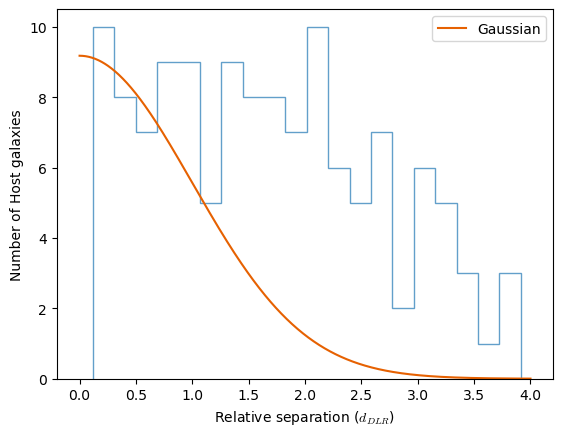

In [814]:
plt.hist(filtered_dDLR, bins=20, histtype='step', alpha=0.7, rwidth=0.85)
plt.xlabel('Relative separation ($d_{DLR}$)')
plt.ylabel('Number of Host galaxies')

# Define Gaussian function
def gaussian(x, mean, sigma):
    return (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / sigma)**2)

# Generate x values for the Gaussian curve
x = np.linspace(0,4, 1000)
y = gaussian(x, 0, 1)*23

plt.plot(x, y,color='#e66101', label='Gaussian')
plt.legend()

Write d_DLR and the name to a dataframe

In [139]:
name_dlr = []
for i in range(len(FN_shapes['CID'])):
    name_dlr.append([FN_shapes['CID'][i], float(d_DLR[i])])
        
Host_dlr = pd.DataFrame(name_dlr, columns=['CID', 'd_DLR'])
Host_dlr.to_csv('Host_dlr.csv', index=True)


## Brandnew attempt to calculate the DLR

### Angular separation between SN and Host galaxy

In [63]:
FN_Host_properties = pd.read_csv('FN_Host_properties.csv')
FN_shapes = pd.read_csv('FN_shapes.csv')
FN_shapeparams = pd.read_csv('FN_shapeparams2.csv')
FN_shapeparams

,Names,a,b,theta
0,SN2016coj,34.646023,14.846487,-0.086077
1,2018gv,29.111597,9.148037,-0.340501
2,2019np,33.805931,11.056870,-0.745121
3,2017erp,2.686535,1.088535,0.447977
4,ASASSN-15so,37.446980,13.065867,-0.354212
...,...,...,...,...
159,AT2016gsu,7.367836,6.045934,-0.501265
160,Gaia16acv,4.766856,3.094555,-0.201087
161,PS15bzz,8.669806,7.872557,1.524861
162,SN2016glp,10.563931,8.133194,1.024131


In [32]:
SN_RA = np.array(FN_Host_properties['SN_RA'])
SN_DEC = np.array(FN_Host_properties['SN_DEC'])
HOST_RA = np.array(FN_Host_properties['HOST_RA'])
HOST_DEC = np.array(FN_Host_properties['HOST_DEC'])

In [33]:
# angular separation between SN and host using formular
ANG_SEP = [] # arcsec
for i in range(len(SN_RA)):
    ang_sep_deg = np.sqrt((SN_RA[i]-HOST_RA[i])**2 + (SN_DEC[i]-HOST_DEC[i])**2)
    ang_sep_arcsec = (ang_sep_deg*(u.deg)).to(u.arcsec)
    ANG_SEP.append(ang_sep_arcsec.value)
min(ANG_SEP),max(ANG_SEP),np.median(ANG_SEP)

(0.248817041217442, 175.88225079301225, 6.374220378007436)

### DLR

In [74]:
# Get the pixel scale of the image
index = 0 # 2021dha
#survey = 'PS1'
obj_dir = os.path.join(workdir, '2021dha')
obj_PS1fits = os.path.join(obj_dir, f"{'PS1'}_{'riz'}.fits")
#obj_SDSSfits = os.path.join(obj_dir, f"{'SDSS'}_{'riz'}.fits")
img_wcs_PS1 = AsWCS.WCS(fitsio.read_header(obj_PS1fits), naxis=2)
#img_wcs_SDSS = AsWCS.WCS(fitsio.read_header(obj_SDSSfits), naxis=2)

pixel_scale_PS1 = (img_wcs_PS1.proj_plane_pixel_scales())[0].to(u.arcsec)

In [75]:
# Convert the semi-major and semi-minor axes to arcsec
semi_major = []
semi_minor = []
for i in range(len(FN_shapes)):
    semi_major.append(FN_shapes['a'][i]*pixel_scale_PS1)
    semi_minor.append(FN_shapes['b'][i]*pixel_scale_PS1)

In [76]:
def compute_position_angle(name,survey,theta, filt='riz'):
    # Load the WCS information
    obj_dir = os.path.join(workdir, name)
    obj_fits = os.path.join(obj_dir, f"{survey}_{filt}.fits")
    img_wcs = WCS(fitsio.read_header(obj_fits))

    # Compute the rotation angle of the image in degree
    rotation_angle = (img_wcs.get_rot())
    # This is a rotation angle of zero aligns north along the positive Y axis, 
    # A positive rotation angle rotates north away from the Y axis, in the sense of a rotation from north to east.


    # Convert the provided theta to position angle
    position_angle = np.deg2rad((-rotation_angle) - 90 + np.rad2deg(theta))

    # First normalize to -pi to pi
    normalized_PA = (position_angle + np.pi) % (2 * np.pi) - np.pi

    # Now adjust to -pi/2 to pi/2
    if normalized_PA < -np.pi / 2:
        normalized_PA += np.pi
    elif normalized_PA > np.pi / 2:
        normalized_PA -= np.pi

    return normalized_PA

In [78]:
# Convert the orientation of theta
PA = []
for i in range(len(FN_shapes)):
    theta = FN_shapes['theta'][i]
    name = FN_shapes['CID'][i]
    PA.append(compute_position_angle(name,'PS1',theta))

In [80]:
DLRs = [] # arcsec
for i in range(len(semi_major)):
    DLR = (semi_major[i]*semi_minor[i])/(np.sqrt((semi_major[i]*np.sin(PA[i]))**2 + (semi_minor[i]*np.cos(PA[i]))**2))
    DLRs.append(DLR.value)

In [81]:
min(DLRs),max(DLRs),np.median(DLRs)

(0.24143259886506058, 23.54300437845388, 2.5906265824326353)

### dDLR

In [82]:
dDLR = []
for i in range(len(DLRs)):
    dDLR.append(ANG_SEP[i]/DLRs[i])

In [83]:
min(dDLR),max(dDLR),np.median(dDLR)

(0.05432263873284974, 91.11035259523368, 2.6526408835651636)

In [84]:
filtered_dDLR = [x for x in dDLR if x > 0 and x <= 4]
np.median(filtered_dDLR), min(filtered_dDLR), max(filtered_dDLR)

(1.4582117938082757, 0.05432263873284974, 3.999762237262025)

In [86]:
filtered_DLR = [x for x in DLRs if x > 0 and x <= 4]
np.median(filtered_DLR), min(filtered_DLR), max(filtered_DLR)

(2.157539806142616, 0.24143259886506058, 3.967387381311595)

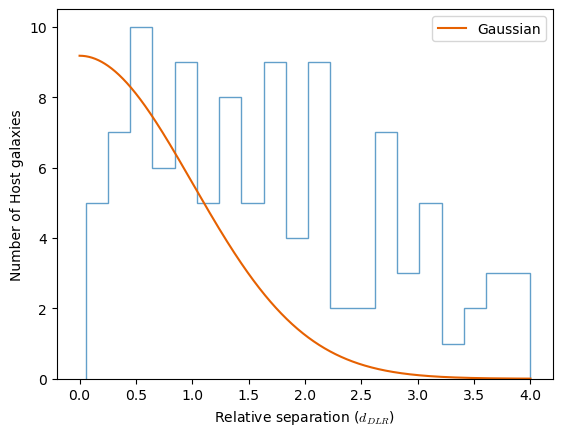

In [85]:
plt.hist(filtered_dDLR, bins=20, histtype='step', alpha=0.7, rwidth=0.85)
plt.xlabel('Relative separation ($d_{DLR}$)')
plt.ylabel('Number of Host galaxies')

# Define Gaussian function
def gaussian(x, mean, sigma):
    return (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / sigma)**2)

# Generate x values for the Gaussian curve
x = np.linspace(0,4, 1000)
y = gaussian(x, 0, 1)*23

plt.plot(x, y,color='#e66101', label='Gaussian')
plt.legend()

## Mass-Mass Plot

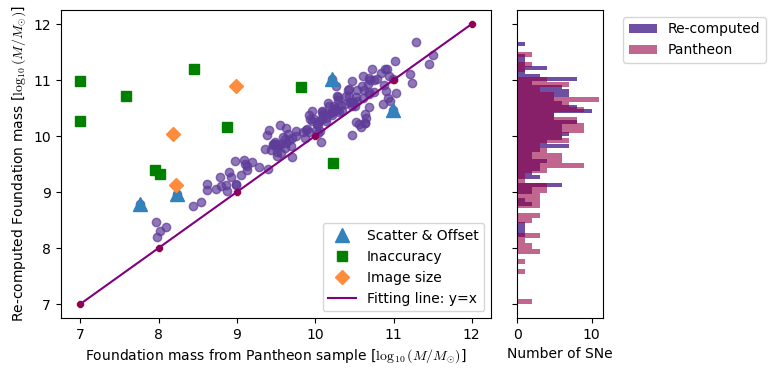

In [3]:
FN_samples_host = pd.read_csv('FN_samples_host_info.csv')
FN_mass_reorder = pd.read_csv('FN_mass_reorder.csv')
Pan_mass_new = pd.read_csv('Pan_mass_new.csv')

FN_mass = FN_mass_reorder['mass']
Pan_mass = Pan_mass_new['mass']

fig = plt.figure(figsize=(7, 4))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(Pan_mass,FN_mass, alpha=0.7,color='#5e3c99')

ax_scatter.plot(dots, dots,'8',color='#980043',markersize=4)

# Adding different markers for categories
# for category, marker in zip(['Offset', 'Inaccuracy', 'Image size'], ['^', 's', 'o']):
#     mask = categories == category
#     ax_scatter.scatter(x[mask], y[mask], marker=marker, label=category)


ax_scatter.plot(8.23133,8.956,'^',markersize=9.5,color='#3182bd',label='Scatter & Offset')
ax_scatter.plot(7.75897,8.782,'^',markersize=9.5,color='#3182bd')
ax_scatter.plot(10.9913,10.462,'^',markersize=9.5,color='#3182bd')
ax_scatter.plot(10.2163,11.014,'^',markersize=9.5,color='#3182bd')

ax_scatter.plot(7.58761,10.722,'s',markersize=7, color='g',label='Inaccuracy')
ax_scatter.plot(8.45606,11.204,'s',markersize=7, color='g')
ax_scatter.plot(7.0,10.259,'s',markersize=7, color='g')
ax_scatter.plot(7.0,10.977,'s',markersize=7, color='g')
ax_scatter.plot(7.95752,9.385,'s',markersize=7, color='g')
ax_scatter.plot(10.227,9.523,'s',markersize=7, color='g')
ax_scatter.plot(8.86694,10.163,'s',markersize=7, color='g')
ax_scatter.plot(9.81701,10.879,'s',markersize=7, color='g')
ax_scatter.plot(8.01649,9.312,'s',markersize=7,color='g')

ax_scatter.plot(8.18544,10.03,'D',markersize=7, color='#fd8d3c',label='Image size')
ax_scatter.plot(8.21725,9.125,'D',markersize=7, color='#fd8d3c')
ax_scatter.plot(8.98827,10.89,'D',markersize=7, color='#fd8d3c')



ax_scatter.plot([7, 12], [7, 12], 'purple',label='Fitting line: y=x')  # Fitting line

ax_scatter.set_xlabel('Foundation mass from Pantheon sample [$\log_{10}(M / M_{\odot})$]')
ax_scatter.set_ylabel('Re-computed Foundation mass [$\log_{10}(M / M_{\odot})$]')
ax_scatter.legend()
ax_scatter.legend(loc='lower right')

# Marginal histogram on the right
ax_hist = fig.add_subplot(grid[1], sharey=ax_scatter)
ax_hist.hist(FN_mass, bins=50, orientation='horizontal', color='#5e3c99', alpha=0.9,label='Re-computed')
ax_hist.hist(Pan_mass, bins=50, orientation='horizontal', color='#980043', alpha=0.6,label='Pantheon')
ax_hist.set_xlabel('Number of SNe')
ax_hist.legend(bbox_to_anchor=(1.15, 1),ncol=1)

# Turn off y-axis labels and ticks for the histogram
ax_hist.yaxis.set_tick_params(labelleft=False)

#plt.savefig('mass_comparison.pdf')
plt.show()



In [171]:
difference = FN_mass-Pan_mass
stddev = np.std(difference)
print('Standard deviation:',stddev)

Standard deviation: 0.5900377257212055


In [176]:
print('ATLAS16dqf:',0.782/stddev,'sigma away from the mean relation')
print('ASASSN-16la:',0.956/stddev,'sigma away from the mean relation')
print('AT2016eoa:',0.814/stddev,'sigma away from the mean relation')
print('ASASSN-15mf:',0.462/stddev,'sigma away from the mean relation')


ATLAS16dqf: 1.325338984120309 sigma away from the mean relation
ASASSN-16la: 1.620235382121503 sigma away from the mean relation
AT2016eoa: 1.3795728044423676 sigma away from the mean relation
ASASSN-15mf: 0.7830007808997222 sigma away from the mean relation


In [10]:
FN_z = []

for name in FN_mass_reorder['name']:
    if name in FN_samples_host['CID'].values:
        zHD = FN_samples_host.loc[FN_samples_host['CID'] == name, 'zHD'].values[0]
        FN_z.append(zHD)
    else:
        continue

In [11]:
len(FN_z),len(FN_mass)

(164, 164)

## Compute rest frame host color

In [156]:
def host_ur_color(file_path):
    conts_c=(c.c).value
    h=(c.h).value
    # Load Bessel transmission curves using PyAstronomy
    trans_curves = pyasl.TransmissionCurves()
    interpolator_u = trans_curves.getTransCurve("Bessel u")
    interpolator_r = trans_curves.getTransCurve("Bessel r")
    u_wvl = np.arange(3000, 4250, 50)
    r_wvl = np.arange(5500, 9100, 100)

    # Read data, skipping rows with errors
    data_clean = []
    with open(file_path, 'r') as file:
        for line in file:
            try:
                wavelength, flux = map(float, line.split())
                if u_wvl[0] <= wavelength <= r_wvl[-1]:  # Consider only relevant wavelengths
                    data_clean.append([wavelength, flux])
            except ValueError:
                continue

    data_clean = np.array(data_clean)
    if data_clean.size == 0:
        return None  # Return None if data is empty or invalid

    # Use only wavelengths within the effective range of each filter
    u_mask = (data_clean[:, 0] >= u_wvl[0]) & (data_clean[:, 0] <= u_wvl[-1])
    r_mask = (data_clean[:, 0] >= r_wvl[0]) & (data_clean[:, 0] <= r_wvl[-1])

    # Interpolate transmission functions to the corresponding wavelengths
    u_transmission = interpolator_u(data_clean[u_mask, 0])
    r_transmission = interpolator_r(data_clean[r_mask, 0])

    # Calculate integrated fluxes
    u_upper = np.trapz(y=data_clean[u_mask, 1] * u_transmission, x=data_clean[u_mask, 0])
    u_lower = np.trapz(y=u_transmission * data_clean[u_mask, 0], x=data_clean[u_mask, 0])
    flux_u = u_upper/u_lower

    r_upper = np.trapz(y=data_clean[r_mask, 1] * r_transmission* data_clean[r_mask, 0], x=data_clean[r_mask, 0])
    r_lower = np.trapz(y=r_transmission* data_clean[r_mask, 0], x=data_clean[r_mask, 0])
    flux_r = r_upper/r_lower

    # Convert to magnitudes and calculate (u-r) color
    if flux_u > 0 and flux_r > 0:
        magnitude_u = -2.5 * np.log10(flux_u)
        magnitude_r = -2.5 * np.log10(flux_r)
        return magnitude_u - magnitude_r
    return None


# Iterate over each file in the directory
folder_path = "sedfitting_data"
results = []
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)
        color = host_ur_color(file_path)
        results.append([filename[:-4], color])

# Convert results to a DataFrame and save as CSV
Host_color = pd.DataFrame(results, columns=['Names', 'u-r Color'])
Host_color.to_csv('Host_ur_colors.csv', index=False)

In [157]:
np.median(Host_color['u-r Color']), np.mean(Host_color['u-r Color']), np.std(Host_color['u-r Color']), np.min(Host_color['u-r Color']), np.max(Host_color['u-r Color'])

(0.386108830408574,
 0.3699625809046105,
 0.3891408844575132,
 -0.5117020781736699,
 1.2398883721290588)

## SN light-curve parameters

delete missing SN from original list; match the order; plot SN color vs Host color, SN stretch vs Host color, SN color vs Host mass

In [158]:
# # Reorder the ALL_data_FN to match the FN_samples
SN_lightcurves = pd.read_csv('SN_lightcurves.csv')
Host_color['Names'] = pd.Categorical(Host_color['Names'], categories=SN_lightcurves['Names'])
host_color_reorder = Host_color.sort_values('Names')
host_color_reorder.to_csv('host_color_reorder.csv', index=False)
host_color_reorder = pd.read_csv('host_color_reorder.csv')
host_color_reorder.to_csv('host_color_reorder.csv', index=True)

In [72]:
Host_color_Vega_reorder = pd.read_csv('Host_color_Vega_reorder.csv')
SN_lightcurves = pd.read_csv('SN_lightcurves.csv')
SNcolor = SN_lightcurves['c']
SNstretch = SN_lightcurves['x1']
# Host_color_reordered = pd.read_csv('host_color_reorder.csv')
# hostcolor = Host_color_reordered['u-r Color']
# new_list = Host_color_reordered['u-r Color']+0.58
# ((Host_color_reordered.replace(list(hostcolor),list(new_list))).drop(columns=['Unnamed: 0'])).to_csv('Host_color_converted.csv', index=False)


# missing_index = [8,47,49,104,114,116,119,133,137,138,158,161,167,173,178]
# SN_c = list(FN_samples_host['c'])
# SN_c = [SN_c[i] for i in range(len(SN_c)) if i not in missing_index]
# SN_x1 = list(FN_samples_host['x1'])
# SN_x1 = [SN_x1[i] for i in range(len(SN_x1)) if i not in missing_index]
# SN_name = list(FN_samples_host['CID'])
# SN_name = [SN_name[i] for i in range(len(SN_name)) if i not in missing_index]

# SN_lightcurves = pd.DataFrame(list(zip(SN_name, SN_c, SN_x1)), columns=['Names', 'c', 'x1'])
# SN_lightcurves.to_csv('SN_lightcurves.csv', index=True)



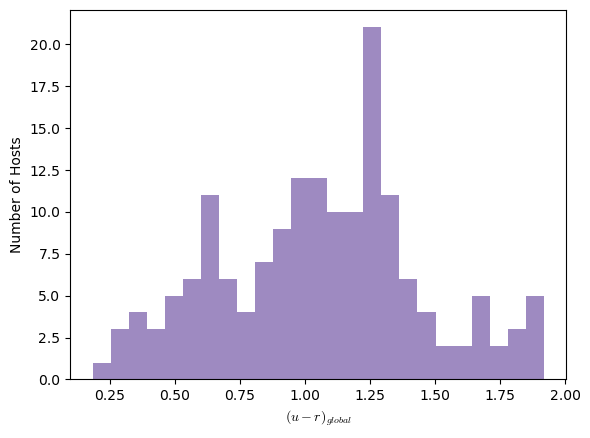

In [75]:
plt.hist(Host_color_Vega_reorder['u-r Color'], bins=25,histtype='stepfilled', alpha=0.6,color='#5e3c99')
#plt.xlim(0, 2)
plt.xlabel('$(u-r)_{global}$')
plt.ylabel('Number of Hosts')
plt.savefig('Host_color_hist.pdf')

## Host color vs SN light-curve parameters

### (u-r) vs c

In [151]:
# Merge the dataframes on the "Names" column
# Host_color_Vega_reorder = pd.read_csv('Host_color_Vega_reorder.csv')
# host_color_reorder = pd.read_csv('host_color_reorder.csv')
merged_Color = pd.merge(Host_color_Vega_reorder, SN_lightcurves, on="Names")

# Split the dataframe into two subsamples at the median of "u-r Color"
median_ur_color = merged_Color["u-r Color"].median()
subsample1 = merged_Color[merged_Color["u-r Color"] <= median_ur_color]
subsample2 = merged_Color[merged_Color["u-r Color"] > median_ur_color]

# Compute the weighted mean for each subsample
def weighted_mean(df, value_column, weight_column):
    return (df[value_column]* df[weight_column] ).sum() / df[weight_column].sum()

def leastSfit(x1,x2,y1,y2,list):
    x = np.array([x1,x2])
    y = np.array([y1,y2])

    # Perform the least squares linear fit
    coefficients = np.polyfit(x, y, 1)

    # Extract the slope and intercept from the coefficients
    m = coefficients[0]
    b = coefficients[1]

    x_line = np.linspace(min(list),max(list) ,100)
    y_line = m * x_line + b
    return x_line, y_line

# weighted_mean_hostcolor1 = weighted_mean(subsample1, "u-r Color", "u-r Color")
# weighted_mean_SNcolor1 = weighted_mean(subsample1, "c", "u-r Color")

# weighted_mean_hostcolor2 = weighted_mean(subsample2, "u-r Color", "u-r Color")
# weighted_mean_SNcolor2 = weighted_mean(subsample2, "c", "u-r Color")

weighted_mean_hostcolor1 = np.mean(subsample1["u-r Color"])
weighted_mean_SNcolor1 = np.mean(subsample1["c"])

weighted_mean_hostcolor2 = np.mean(subsample2["u-r Color"])
weighted_mean_SNcolor2 = np.mean(subsample2["c"])

In [152]:
weighted_mean_hostcolor1,weighted_mean_hostcolor2,weighted_mean_SNcolor1,weighted_mean_SNcolor2,median_ur_color

(0.7471773953705563,
 1.363791287386685,
 -0.02992898780487805,
 0.0060357560975609756,
 1.0733462704116121)

In [153]:
from scipy.stats import bootstrap
from scipy.stats import norm
data1_ur = np.array(subsample1['u-r Color'])
data1_ur = (data1_ur,)
res1_ur = bootstrap(data1_ur, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
ur1_err = res1_ur.standard_error 

data1_c = np.array(subsample1['c'])
data1_c = (data1_c,)
res1_c = bootstrap(data1_c, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
c1_err = res1_c.standard_error 

data2_ur = np.array(subsample2['u-r Color'])
data2_ur = (data2_ur,)
res2_ur = bootstrap(data2_ur, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
ur2_err = res2_ur.standard_error 

data2_c = np.array(subsample2['c'])
data2_c = (data2_c,)
res2_c = bootstrap(data2_c, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
c2_err = res2_c.standard_error 

err_1_x = [ur1_err,ur2_err]
err_1_y = [c1_err,c2_err]

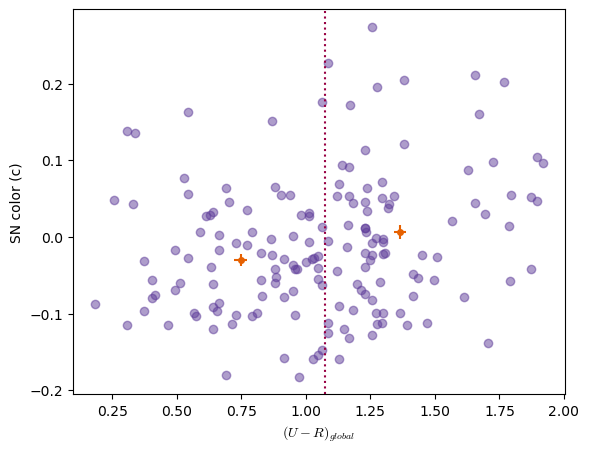

In [154]:
fig = plt.figure(figsize=(8, 5))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(merged_Color["u-r Color"],SNcolor, alpha=0.5,color='#5e3c99')
ax_scatter.axvline(x=median_ur_color,linestyle='dotted',color='#980043',markersize=4)
#ax_scatter.axhline(y=np.median(SNcolor),linestyle='dotted',color='#980043',markersize=4)
#ax_scatter.plot([weighted_mean_hostcolor1,weighted_mean_hostcolor2],[weighted_mean_SNcolor1,weighted_mean_SNcolor2])
                #,'X',color='#e66101',markersize=10)
ax_scatter.errorbar([weighted_mean_hostcolor1,weighted_mean_hostcolor2],[weighted_mean_SNcolor1,weighted_mean_SNcolor2]
                    ,xerr=err_1_x,yerr=err_1_y,fmt='o',color='#e66101',markersize=4)
# ax_scatter.plot(weighted_mean_hostcolor2,weighted_mean_SNcolor2,'X',color='#e66101',markersize=10)
# ax_scatter.plot(leastSfit(weighted_mean_hostcolor1,weighted_mean_hostcolor2,weighted_mean_SNcolor1,weighted_mean_SNcolor2,merged_Color["u-r Color"])[0], 
#                 leastSfit(weighted_mean_hostcolor1,weighted_mean_hostcolor2,weighted_mean_SNcolor1,weighted_mean_SNcolor2,merged_Color["u-r Color"])[1], 
#                 'b',linestyle='dashed',label='Fitting line: y=0.04x+0.07')  # Fitting line


ax_scatter.set_xlabel('$(U-R)_{global}$')
ax_scatter.set_ylabel('SN color (c)')
# ax_scatter.axes.set_xlim(-0.5, 1.3)
# ax_scatter.axes.set_ylim(-0.25, 0.3)
#ax_scatter.legend()
#ax_scatter.legend(loc='lower right')
plt.savefig('FN host-SN color.png')
plt.show()


### (u-r) vs x1

In [148]:
# weighted_mean_SNstretch1 = weighted_mean(subsample1, "x1", "u-r Color")
# weighted_mean_SNstretch2 = weighted_mean(subsample2, "x1", "u-r Color")
weighted_mean_SNstretch1 = np.mean(subsample1["x1"])
weighted_mean_SNstretch2 = np.mean(subsample2["x1"])

In [149]:
data1_ur = np.array(subsample1['u-r Color'])
data1_ur = (data1_ur,)
res1_ur = bootstrap(data1_ur, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
ur1_err = res1_ur.standard_error 

data1_x1 = np.array(subsample1['x1'])
data1_x1 = (data1_x1,)
res1_x1 = bootstrap(data1_x1, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
x1_err = res1_x1.standard_error 

data2_ur = np.array(subsample2['u-r Color'])
data2_ur = (data2_ur,)
res2_ur = bootstrap(data2_ur, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
ur2_err = res2_ur.standard_error 

data2_x1 = np.array(subsample2['x1'])
data2_x1 = (data2_x1,)
res2_x1 = bootstrap(data2_x1, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
x12_err = res2_x1.standard_error 

err_1x = [ur1_err,ur2_err]
err_1y = [x1_err,x12_err]

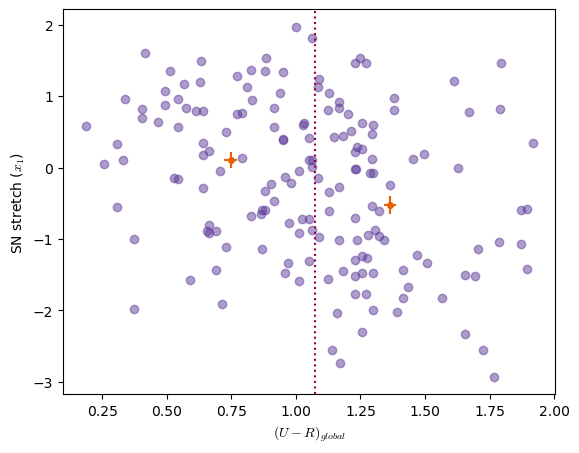

In [155]:
fig = plt.figure(figsize=(8, 5))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(merged_Color["u-r Color"],SNstretch, alpha=0.5,color='#5e3c99')
ax_scatter.axvline(x=median_ur_color,linestyle='dotted',color='#980043',markersize=4)
#ax_scatter.axhline(y=np.median(SNcolor),linestyle='dotted',color='#980043',markersize=4)
# ax_scatter.plot(weighted_mean_hostcolor1,weighted_mean_SNstretch1,'X',color='#e66101',markersize=8)
# ax_scatter.plot(weighted_mean_hostcolor2,weighted_mean_SNstretch2,'X',color='#e66101',markersize=8)
# ax_scatter.plot(leastSfit(weighted_mean_hostcolor1,weighted_mean_hostcolor2,weighted_mean_SNstretch1,weighted_mean_SNstretch2,merged_Color["u-r Color"])[0], 
#                 leastSfit(weighted_mean_hostcolor1,weighted_mean_hostcolor2,weighted_mean_SNstretch1,weighted_mean_SNstretch2,merged_Color["u-r Color"])[1], 
#                 'b',linestyle='dashed',label='Fitting line: y=0.04x+0.07')  # Fitting line
ax_scatter.errorbar([weighted_mean_hostcolor1,weighted_mean_hostcolor2],[weighted_mean_SNstretch1,weighted_mean_SNstretch2]
                    ,xerr=err_1x,yerr=err_1y,fmt='o',color='#e66101',markersize=4)

ax_scatter.set_xlabel('$(U-R)_{global}$')
ax_scatter.set_ylabel('SN stretch ($x_{1}$)')
# ax_scatter.axes.set_xlim(0.2, 2.5)
# ax_scatter.axes.set_ylim(-0.6, 0.3)
#ax_scatter.legend()
#ax_scatter.legend(loc='lower right')
plt.savefig('FN host-SN stretch.png')
plt.show()

## Host mass vs SN light-curve parameters

### M vs c

In [156]:
FN_mass_reorder = pd.read_csv('FN_mass_reorder.csv')
FN_mass = FN_mass_reorder['mass']

# Merge the dataframes on the "Names" column

merged_Mass = pd.merge(FN_mass_reorder, SN_lightcurves, on="Names")

# Split the dataframe into two subsamples at the median of "u-r Color"
median_hostM = merged_Mass["mass"].median()
subsample_1 = merged_Mass[merged_Mass["mass"] <= median_hostM]
subsample_2 = merged_Mass[merged_Mass["mass"] > median_hostM]

# weighted_mean_hostM1 = weighted_mean(subsample_1, "mass", "mass")
# weighted_mean_SNc1 = weighted_mean(subsample_1, "c", "mass")

# weighted_mean_hostM2 = weighted_mean(subsample_2, "mass", "mass")
# weighted_mean_SNc2 = weighted_mean(subsample_2, "c", "mass")

weighted_mean_hostM1 = np.mean(subsample_1["mass"])
weighted_mean_SNc1 = np.mean(subsample_1["c"])

weighted_mean_hostM2 = np.mean(subsample_2["mass"])
weighted_mean_SNc2 = np.mean(subsample_2["c"])

In [157]:
data1_m = np.array(subsample_1['mass'])
data1_m = (data1_m,)
res1_m = bootstrap(data1_m, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
m1_err = res1_m.standard_error 

data1_c = np.array(subsample_1['c'])
data1_c = (data1_c,)
res1_c = bootstrap(data1_c, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
c1_err = res1_c.standard_error 

data2_m = np.array(subsample_2['mass'])
data2_m = (data2_m,)
res2_m = bootstrap(data2_m, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
m2_err = res2_m.standard_error 

data2_c = np.array(subsample_2['c'])
data2_c = (data2_c,)
res2_c = bootstrap(data2_c, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
c2_err = res2_c.standard_error 

err_x = [m1_err,m2_err]
err_y = [c1_err,c2_err]

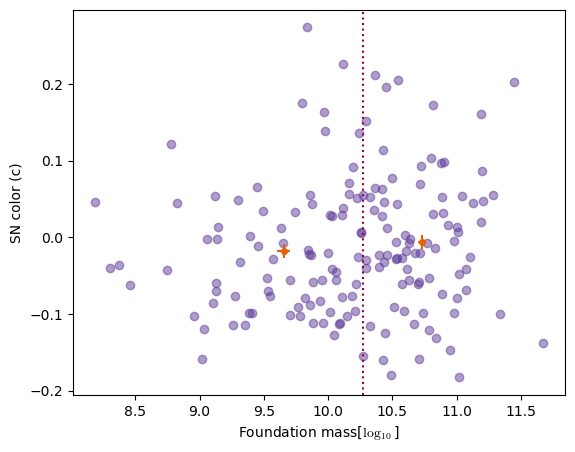

In [158]:
fig = plt.figure(figsize=(8, 5))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(FN_mass,SNcolor, alpha=0.5,color='#5e3c99')
ax_scatter.axvline(median_hostM,linestyle='dotted',color='#980043',markersize=4)
#ax_scatter.axhline(y=np.median(SNcolor),linestyle='dotted',color='#980043',markersize=4)
# ax_scatter.plot(weighted_mean_hostM1,weighted_mean_SNc1,'X',color='#e66101',markersize=8)
# ax_scatter.plot(weighted_mean_hostM2,weighted_mean_SNc2,'X',color='#e66101',markersize=8)
# ax_scatter.plot(leastSfit(weighted_mean_hostM1,weighted_mean_hostM2,weighted_mean_SNc1,weighted_mean_SNc2,FN_mass)[0], 
#                 leastSfit(weighted_mean_hostM1,weighted_mean_hostM2,weighted_mean_SNc1,weighted_mean_SNc2,FN_mass)[1], 
#                 'b',linestyle='dashed',label='Fitting line: y=0.04x+0.07')  # Fitting line
ax_scatter.errorbar([weighted_mean_hostM1,weighted_mean_hostM2],[weighted_mean_SNc1,weighted_mean_SNc2]
                    ,xerr=err_x,yerr=err_y,fmt='o',color='#e66101',markersize=4)

ax_scatter.set_xlabel('Foundation mass[$\log_{10}$]')
ax_scatter.set_ylabel('SN color (c)')
# ax_scatter.axes.set_xlim(0.2, 2.5)
# ax_scatter.axes.set_ylim(-0.25, 0.3)
#ax_scatter.legend()
#ax_scatter.legend(loc='lower right')
plt.savefig('FN hostM-SNc.png')
plt.show()

### M vs x1

In [159]:
weighted_mean_SNx1 = np.mean(subsample_1['x1'])
weighted_mean_SNx2 = np.mean(subsample_2['x1'])

In [160]:
data1_m = np.array(subsample_1['mass'])
data1_m = (data1_m,)
res1_m = bootstrap(data1_m, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
m1_err = res1_m.standard_error 

data1_x1 = np.array(subsample_1['x1'])
data1_x1 = (data1_x1,)
res1_x1 = bootstrap(data1_x1, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
x11_err = res1_x1.standard_error 

data2_m = np.array(subsample_2['mass'])
data2_m = (data2_m,)
res2_m = bootstrap(data2_m, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
m2_err = res2_m.standard_error 

data2_x1 = np.array(subsample_2['x1'])
data2_x1 = (data2_x1,)
res2_x1 = bootstrap(data2_x1, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
x12_err = res2_x1.standard_error 

err_x = [m1_err,m2_err]
err_y = [x11_err,x12_err]

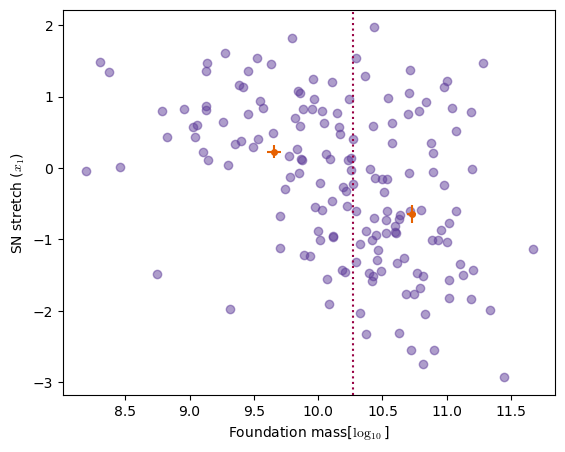

In [161]:
fig = plt.figure(figsize=(8, 5))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(FN_mass,SNstretch, alpha=0.5,color='#5e3c99')
ax_scatter.axvline(median_hostM,linestyle='dotted',color='#980043',markersize=4)
#ax_scatter.axhline(y=np.median(SNcolor),linestyle='dotted',color='#980043',markersize=4)
# ax_scatter.plot(weighted_mean_hostM1,weighted_mean_SNx1,'X',color='#e66101',markersize=8)
# ax_scatter.plot(weighted_mean_hostM2,weighted_mean_SNx2,'X',color='#e66101',markersize=8)
# ax_scatter.plot(leastSfit(weighted_mean_hostM1,weighted_mean_hostM2,weighted_mean_SNx1,weighted_mean_SNx2,FN_mass)[0], 
#                 leastSfit(weighted_mean_hostM1,weighted_mean_hostM2,weighted_mean_SNx1,weighted_mean_SNx2,FN_mass)[1], 
#                 'b',linestyle='dashed',label='Fitting line: y=0.04x+0.07')  # Fitting line
ax_scatter.errorbar([weighted_mean_hostM1,weighted_mean_hostM2],[weighted_mean_SNx1,weighted_mean_SNx2]
                    ,xerr=err_x,yerr=err_y,fmt='o',color='#e66101',markersize=4)

ax_scatter.set_xlabel('Foundation mass[$\log_{10}$]')
ax_scatter.set_ylabel('SN stretch ($x_{1}$)')
# ax_scatter.axes.set_xlim(0.2, 2.5)
# ax_scatter.axes.set_ylim(-0.25, 0.3)
#ax_scatter.legend()
#ax_scatter.legend(loc='lower right')
plt.savefig('FN hostM-SNx1.png')
plt.show()

## DLR vs SN light-curve parameters

### DLR vs c

In [73]:
Host_dDLR = pd.read_csv('Host_dlr.csv')
dDLR = Host_dDLR['d_DLR']

# Merge the dataframes on the "Names" column
Host_dDLR.rename(columns={'CID':'Names'}, inplace=True)
merged_dlr = pd.merge(Host_dDLR, SN_lightcurves, on="Names")
selected_dlr = merged_dlr[(merged_dlr['d_DLR'] > 0) & (merged_dlr['d_DLR'] <= 4)]

# Split the dataframe into two subsamples at the median of "u-r Color"
median_dlr = selected_dlr["d_DLR"].median()
subsample__1 = selected_dlr[selected_dlr["d_DLR"] <= 1.0]
subsample__2 = selected_dlr[selected_dlr["d_DLR"] > 1.0]

w_mean_hostdlr1 = np.mean(subsample__1["d_DLR"])
w_mean_SNc1 = np.mean(subsample__1["c"])

w_mean_hostdlr2 = np.mean(subsample__2["d_DLR"])
w_mean_SNc2 = np.mean(subsample__2["c"])
# missing = [7,110,112,115,132,152,169]
# ori_dlr = (pd.read_csv('Host_dlr.csv')).drop(missing)
# ori_dlr.to_csv('Host_dlr.csv',index=True)

In [756]:
np.mean(selected_dlr['d_DLR']),np.median(selected_dlr['d_DLR'])

(1.585630269613325, 1.541511388985295)

In [76]:
np.median(dDLR),len(dDLR),len(Host_dDLR)

(1.91770225114749, 163, 163)

In [163]:
data1_dlr = np.array(subsample__1['d_DLR'])
data1_dlr = (data1_dlr,)
res1_dlr = bootstrap(data1_dlr, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
dlr1_err = res1_dlr.standard_error 

data1_c = np.array(subsample__1['c'])
data1_c = (data1_c,)
res1_c = bootstrap(data1_c, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
c1_err = res1_c.standard_error 

data2_dlr = np.array(subsample__2['d_DLR'])
data2_dlr = (data2_dlr,)
res2_dlr = bootstrap(data2_dlr, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
dlr2_err = res2_dlr.standard_error 

data2_c = np.array(subsample__2['c'])
data2_c = (data2_c,)
res2_c = bootstrap(data2_c, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
c2_err = res2_c.standard_error 

err_x = [dlr1_err,dlr2_err]
err_y = [c1_err,c2_err]

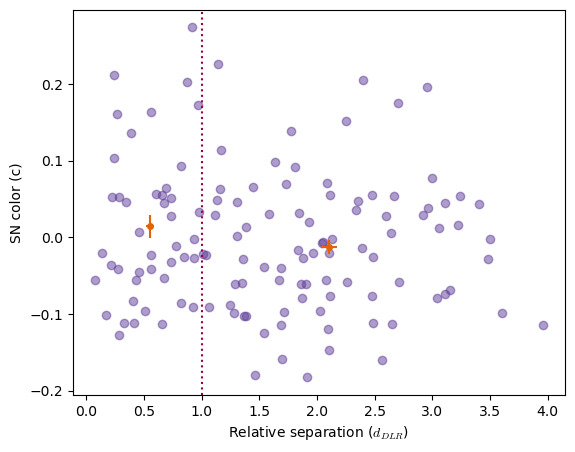

In [164]:
fig = plt.figure(figsize=(8, 5))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(selected_dlr['d_DLR'],selected_dlr['c'], alpha=0.5,color='#5e3c99')
ax_scatter.axvline(1.0,linestyle='dotted',color='#980043',markersize=4)
#ax_scatter.axhline(y=np.median(SNcolor),linestyle='dotted',color='#980043',markersize=4)
# ax_scatter.plot(w_mean_hostdlr1,w_mean_SNc1,'X',color='#e66101',markersize=8)
# ax_scatter.plot(w_mean_hostdlr2,w_mean_SNc2,'X',color='#e66101',markersize=8)
# ax_scatter.plot(leastSfit(w_mean_hostdlr1,w_mean_hostdlr2,w_mean_SNc1,w_mean_SNc2,selected_dlr['d_DLR'])[0], 
#                 leastSfit(w_mean_hostdlr1,w_mean_hostdlr2,w_mean_SNc1,w_mean_SNc2,selected_dlr['d_DLR'])[1], 
#                 'b',linestyle='dashed',label='Fitting line: y=0.04x+0.07')  # Fitting line
ax_scatter.errorbar([w_mean_hostdlr1,w_mean_hostdlr2],[w_mean_SNc1,w_mean_SNc2]
                    ,xerr=err_x,yerr=err_y,fmt='o',color='#e66101',markersize=4)


ax_scatter.set_xlabel('Relative separation ($d_{DLR}$)')
ax_scatter.set_ylabel('SN color (c)')
#ax_scatter.axes.set_xlim(0, 4)
# ax_scatter.axes.set_ylim(-0.25, 0.3)
#ax_scatter.legend()
#ax_scatter.legend(loc='lower right')
plt.savefig('FN hostDLR-SNc.png')
plt.show()

### DLR vs x1

In [165]:
w_mean_SNx1 = np.mean(subsample__1['x1'])
w_mean_SNx2 = np.mean(subsample__2['x1'])

In [166]:
data1_x1 = np.array(subsample__1['x1'])
data1_x1 = (data1_x1,)
res1_x1 = bootstrap(data1_x1, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
x11_err = res1_x1.standard_error 

data2_x1 = np.array(subsample__2['x1'])
data2_x1 = (data2_x1,)
res2_x1 = bootstrap(data2_x1, np.mean, n_resamples=82, confidence_level=0.9, method='percentile')
x12_err = res2_x1.standard_error 

err_x = [dlr1_err,dlr2_err]
err_y = [x11_err,x12_err]

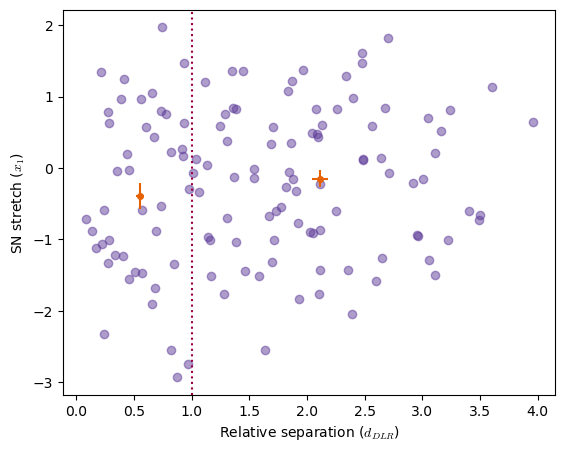

In [167]:
fig = plt.figure(figsize=(8, 5))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(selected_dlr['d_DLR'],selected_dlr['x1'], alpha=0.5,color='#5e3c99')
ax_scatter.axvline(1.0,linestyle='dotted',color='#980043',markersize=4)
#ax_scatter.axhline(y=np.median(SNcolor),linestyle='dotted',color='#980043',markersize=4)
# ax_scatter.plot(w_mean_hostdlr1,w_mean_SNx1,'X',color='#e66101',markersize=8)
# ax_scatter.plot(w_mean_hostdlr2,w_mean_SNx2,'X',color='#e66101',markersize=8)
# ax_scatter.plot(leastSfit(w_mean_hostdlr1,w_mean_hostdlr2,w_mean_SNx1,w_mean_SNx2,selected_dlr['d_DLR'])[0], 
#                 leastSfit(w_mean_hostdlr1,w_mean_hostdlr2,w_mean_SNx1,w_mean_SNx2,selected_dlr['d_DLR'])[1], 
#                 'b',linestyle='dashed',label='Fitting line: y=0.04x+0.07')  # Fitting line
ax_scatter.errorbar([w_mean_hostdlr1,w_mean_hostdlr2],[w_mean_SNx1,w_mean_SNx2]
                    ,xerr=err_x,yerr=err_y,fmt='o',color='#e66101',markersize=4)


ax_scatter.set_xlabel('Relative separation ($d_{DLR}$)')
ax_scatter.set_ylabel('SN stretch ($x_{1}$)')
#ax_scatter.axes.set_xlim(0, 4)
# ax_scatter.axes.set_ylim(-0.25, 0.3)
#ax_scatter.legend()
#ax_scatter.legend(loc='lower right')
plt.savefig('FN hostDLR-SNx1.png')
plt.show()

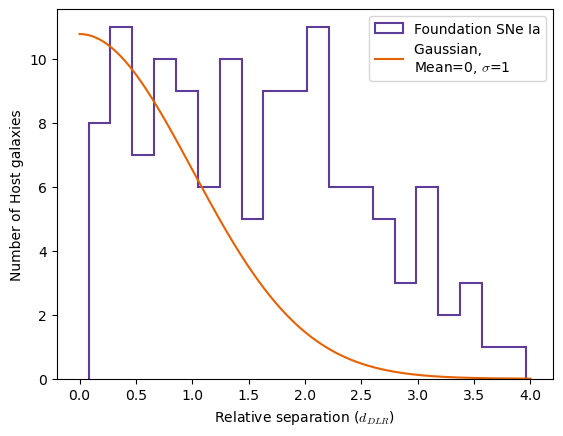

In [448]:
from scipy.stats import norm

plt.hist(selected_dlr['d_DLR'], bins=20,histtype='step',color='#5e3c99',linewidth=1.5,label='Foundation SNe Ia' )
plt.xlabel('Relative separation ($d_{DLR}$)')
plt.ylabel('Number of Host galaxies')


# Define Gaussian function
def gaussian(x, mean, sigma):
    return (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / sigma)**2)

# Generate x values for the Gaussian curve
x = np.linspace(0,4, 1000)
y = gaussian(x, 0, 1) *27

plt.plot(x, y,color='#e66101', label='Gaussian, \nMean=0, $\sigma$=1')
plt.legend()
#plt.savefig('host dDLR dist.pdf')

In [676]:
np.median(selected_dlr['d_DLR'])

1.541511388985295

In [32]:
len(selected_dlr['d_DLR'])

128

## Hubble residuals

$$\Delta \mu = \mu_{\text{obs}}-\mu_{\text{cosmo}} $$
$$\mu_{\text{obs}} = m_{B}-M+\alpha x_{1}-\beta c $$
$$\text{flat}\; \Lambda \text{CDM}\; \text{with}\; \Omega_{0} = 0.326, H_{0}=73.04\,\text{km}\,\text{s}^{-1}\,\text{Mpc}^{-1} $$

In [213]:
FN_samples_host = pd.read_csv('FN_samples_host_info.csv')
FN_mass_reorder = pd.read_csv('FN_mass_reorder.csv')
MU_SH0ES = list(FN_samples_host['MU_SH0ES'])
redshift = list(FN_samples_host['zHD'])
missing_index = [8,47,49,104,114,116,119,133,137,138,158,161,167,173,178] # Hostless and imcomplete
MU_SH0ES = [MU_SH0ES[i] for i in range(len(MU_SH0ES)) if i not in missing_index]
redshift = [redshift[i] for i in range(len(redshift)) if i not in missing_index]
Names_new = list(FN_mass_reorder['Names'])


In [371]:
SN_lightcurves

,Unnamed: 0,Names,c,x1
0,0,SN2016coj,-0.006916,-1.476920
1,1,2018gv,-0.112311,0.120880
2,2,2019np,-0.025372,0.113840
3,3,2017erp,0.071172,0.472180
4,4,ASASSN-15so,-0.055198,-0.714413
...,...,...,...,...
159,159,AT2016gsu,-0.113501,-1.910240
160,160,Gaia16acv,-0.158189,0.568160
161,161,PS15bzz,-0.017322,-0.914595
162,162,SN2016glp,0.135830,0.969120


In [93]:
# Compute observed distance modulus
MB = -19.253
alpha = 0.148
beta = 3.09
cosmo = FlatLambdaCDM(H0=73.04, Om0=0.326)

# mB = list(FN_samples_host['mB'])
# mB = [mB[i] for i in range(len(mB)) if i not in missing_index]
# MU_ob = [mB[i]-MB for i in range(len(mB))] + (alpha*SN_lightcurves['x1'] - beta*SN_lightcurves['c'])
# HR = MU_ob - cosmo.distmod(redshift).value

# Start with 'm_b_corr'
# Add bias correction 'biasCor_m_b'
m_b_corr = list(FN_samples_host['m_b_corr'])
m_b_corr = np.array([m_b_corr[i] for i in range(len(m_b_corr)) if i not in missing_index])

biasCor_m_b = list(FN_samples_host['biasCor_m_b'])
biasCor_m_b = np.array([biasCor_m_b[i] for i in range(len(biasCor_m_b)) if i not in missing_index])

new_m_b = [m_b_corr[i]+biasCor_m_b[i] for i in range(len(m_b_corr))]

# Previous method: m_b_corr + biasCor_m_b - MB - cosmo.distmod(redshift).value
new_HR = ([new_m_b[i] - MB for i in range(len(new_m_b))] -cosmo.distmod(redshift).value)
# FN_HR = pd.DataFrame(list(zip(Names_new, redshift,new_HR)), columns=['Names', 'zHD','new HR'])


In [381]:
## Try Chris's method
## Take off mass step correction'HOST_LOGMASS' with gamma = -0.003
## larger computed mass result in smaller mbCLi, and hence much smaller HR
mbCLi = (np.array(new_m_b)) + 0.003 / (1+np.exp((np.array(FN_mass)-10)/0.01)) -0.003 /2
muCLi = mbCLi - MB
HR_CLi = muCLi - (5* np.log10(cosmo.luminosity_distance(redshift) / u.Mpc) +25)

FN_HR = pd.DataFrame(list(zip(Names_new, redshift, new_HR, HR_CLi)), 
                     columns=['Names', 'zHD', 'new HR','HR_CLi'])

In [245]:
# the mean of Pantheon mass excluding the hostless SNe Ia
np.mean([FN_samples_host['HOST_LOGMASS'][i] for i in range(179) if i not in [47,49,104,133,137,161,167,173]])

9.812626081871345

In [299]:
np.mean(Pan_mass),len(Pan_mass),np.mean(FN_mass),len(FN_mass)

(9.858825548780487, 164, 10.191371951219514, 164)

In [376]:
np.median(HR_CLi),np.mean(HR_CLi) ## Use Pantheon mass

(<Quantity -0.00610995>, <Quantity 0.00261594>)

In [220]:
np.median(HR_CLi),np.mean(HR_CLi) ## use my mass

(<Quantity -0.00610995>, <Quantity 0.0021434>)

## Δμ vs M

In [312]:
#FN_HR = pd.read_csv('FN_HR.csv')
Pan_mass_new = pd.read_csv('Pan_mass_new.csv')
Pan_mass = Pan_mass_new['mass']
Pan_mass_new.rename(columns={'name':'Names','mass':'Mass_Pan'}, inplace=True) # rename the column 'SNID'

In [382]:
#FN_mass_reorder = pd.read_csv('FN_mass_reorder.csv')
FN_samples_host = pd.read_csv('FN_samples_host_info.csv')
FN_mass_reorder = pd.read_csv('FN_mass_reorder.csv')
FN_mass = FN_mass_reorder['mass']

# Merge the dataframes on the "Names" column

merged_HR_M = pd.merge(FN_mass_reorder, FN_HR , on="Names")

median_M = merged_HR_M["mass"].median()
sub1 = merged_HR_M[merged_HR_M["mass"] <= 10]
sub2 = merged_HR_M[merged_HR_M["mass"] > 10]

mean_M1 = np.mean(sub1["mass"])
mean_HR1 = np.mean(sub1["HR_CLi"])

mean_M2 = np.mean(sub2["mass"])
mean_HR2 = np.mean(sub2["HR_CLi"])

In [383]:
from scipy.stats import bootstrap
data1M = (np.array(sub1['mass']), )
res1M = bootstrap(data1M, np.median, confidence_level=0.9,method='percentile')
std_1M = res1M.standard_error
data1HR = (np.array(sub1['HR_CLi']), )
res1HR = bootstrap(data1HR, np.median, confidence_level=0.9,method='percentile')
std_1HR = res1HR.standard_error

data2M = (np.array(sub2['mass']), )
res2M = bootstrap(data2M, np.median, confidence_level=0.9,method='percentile')
std_2M = res2M.standard_error
data2HR = (np.array(sub2['HR_CLi']), )
res2HR = bootstrap(data2HR, np.median, confidence_level=0.9,method='percentile')
std_2HR = res2HR.standard_error

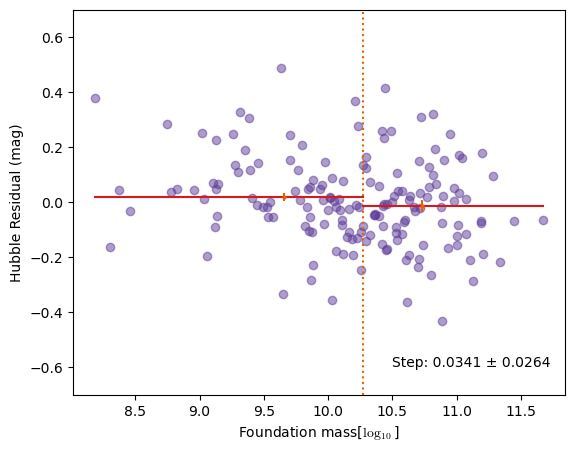

In [355]:
fig = plt.figure(figsize=(8, 5))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
y1 = [mean_HR1]*100
x1 = np.linspace(np.min(sub1["mass"]),np.max(sub1["mass"]),100)
y2 = [mean_HR2]*100
x2 = np.linspace(np.min(sub2["mass"]),np.max(sub2["mass"]),100)
# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(merged_HR_M["mass"],merged_HR_M['HR_CLi'], alpha=0.5,color='#5e3c99')
ax_scatter.axvline(median_M,linestyle='dotted',color='#e66101',markersize=4)
# ax_scatter.plot(mean_M1,mean_HR1,'X',color='#e66101',markersize=10)
# ax_scatter.plot(mean_M2,mean_HR2,'X',color='#e66101',markersize=10)
# ax_scatter.plot(leastSfit(mean_M1,mean_M2,mean_HR1,mean_HR2,merged_HR_M["mass"])[0], 
#                 leastSfit(mean_M1,mean_M2,mean_HR1,mean_HR2,merged_HR_M["mass"])[1], 'b',linestyle='dashed')
#ax_scatter.plot([mean_M1,mean_M2],[mean_HR1,mean_HR2],'X',color='#e66101',markersize=10)
ax_scatter.plot(x1,y1,color='#d7191c',markersize=4)
ax_scatter.plot(x2,y2,color='#d7191c',markersize=4)
ax_scatter.errorbar([mean_M1,mean_M2],[mean_HR1,mean_HR2],yerr=[std_1HR,std_2HR],fmt='o',color='#e66101',markersize=2)

ax_scatter.set_xlabel('Foundation mass[$\log_{10}$]')
ax_scatter.set_ylabel('Hubble Residual (mag)')
# ax_scatter.axes.set_xlim(0.2, 2.5)
ax_scatter.axes.set_ylim(-0.7, 0.7)
ax_scatter.text(10.5, -0.6, f'Step: {(mean_HR1-mean_HR2):.4f} ± {FN_HR_unc:.4f}', fontsize=10)
#ax_scatter.legend()
#ax_scatter.legend(loc='lower right')

plt.savefig('FN_HR vs M.pdf')
plt.show()

In [384]:
FN_HR_unc = np.sqrt(std_1HR**2 + std_2HR**2)
print(f'The mass-step is: {(mean_HR1-mean_HR2):.4f}, with uncertainty:{FN_HR_unc:.4f}')

The mass-step is: 0.0730, with uncertainty:0.0243


## Δμ vs M (inner region)

In [353]:
Host_dDLR = pd.read_csv('Host_dlr.csv')
Host_dDLR.rename(columns={'CID':'Names'}, inplace=True)
merged_HR_M_dlr = pd.merge(merged_HR_M,Host_dDLR,on="Names")
median_Mass = merged_HR_M_dlr["mass"].median()
median_dlr = merged_HR_M_dlr["d_DLR"].median()
# Split the whole data set at dDLR == 1.0
inner_region = merged_HR_M_dlr[merged_HR_M_dlr['d_DLR'] <= 1.0]
innerM_median  = inner_region["mass"].median()
sub1_inner = inner_region[inner_region["mass"] <= median_Mass]
sub2_inner = inner_region[inner_region["mass"] > median_Mass]
meanM_inner1 = np.mean(sub1_inner["mass"])
meanM_inner2 = np.mean(sub2_inner["mass"])
meanHR_inner1 = np.mean(sub1_inner["HR_CLi"])
meanHR_inner2 = np.mean(sub2_inner["HR_CLi"])


In [354]:
from scipy.stats import bootstrap
inner1M = (np.array(sub1_inner['mass']), )
resinner1M = bootstrap(inner1M, np.mean, confidence_level=0.9,method='percentile')
std_inner1M = resinner1M.standard_error
inner1HR = (np.array(sub1_inner['HR_CLi']), )
resinner1HR = bootstrap(inner1HR, np.mean, confidence_level=0.9,method='percentile')
std_inner1HR = resinner1HR.standard_error

inner2M = (np.array(sub2_inner['mass']), )
resinner2M = bootstrap(inner2M, np.mean, confidence_level=0.9,method='percentile')
std_inner2M = resinner2M.standard_error
inner2HR = (np.array(sub2_inner['HR_CLi']), )
resinner2HR = bootstrap(inner2HR, np.mean, confidence_level=0.9,method='percentile')
std_inner2HR = resinner2HR.standard_error

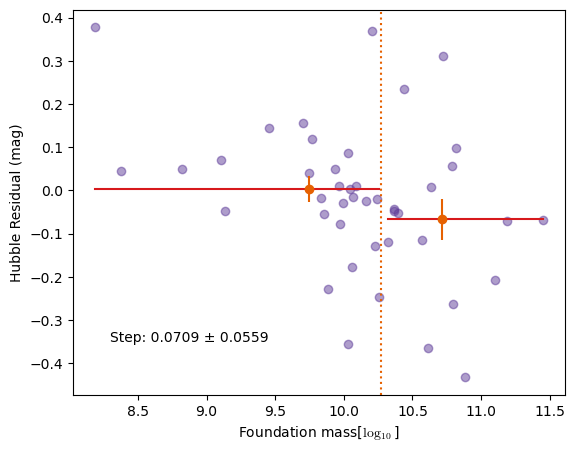

In [357]:
# HR vs M at inner regions
fig = plt.figure(figsize=(8, 5))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
# y1 = [mean_HR1]*100
x1 = np.linspace(np.min(sub1_inner["mass"]),np.max(sub1_inner["mass"]),100)
# y2 = [mean_HR2]*100
x2 = np.linspace(np.min(sub2_inner["mass"]),np.max(sub2_inner["mass"]),100)

# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(inner_region["mass"],inner_region['HR_CLi'], alpha=0.5,color='#5e3c99')
ax_scatter.axvline(median_Mass,linestyle='dotted',color='#e66101',markersize=4)
# ax_scatter.plot([meanM_inner1,meanM_inner2],[meanHR_inner1,meanHR_inner2],
#                 'X',color='#e66101',markersize=10)

ax_scatter.plot(x1,[meanHR_inner1]*100,color='#d7191c',markersize=4)
ax_scatter.plot(x2,[meanHR_inner2]*100,color='#d7191c',markersize=4)
ax_scatter.errorbar([meanM_inner1,meanM_inner2],[meanHR_inner1,meanHR_inner2],
                    yerr=[std_inner1HR,std_inner2HR],fmt='o',color='#e66101',markersize=6)

ax_scatter.set_xlabel('Foundation mass[$\log_{10}$]')
ax_scatter.set_ylabel('Hubble Residual (mag)')
ax_scatter.text(8.3, -0.35, f'Step: {(meanHR_inner1-meanHR_inner2):.4f} ± {(np.sqrt(std_inner1HR**2 + std_inner2HR**2)):.4f}', fontsize=10)
# ax_scatter.axes.set_xlim(0.2, 2.5)
#ax_scatter.axes.set_ylim(-0.7, 0.7)
#ax_scatter.legend()
#ax_scatter.legend(loc='lower right')
plt.savefig('FN_HR vs M_inner.pdf')
plt.show()

In [267]:
print(f'The Hubble residual difference at inner region is: {(meanHR_inner1-meanHR_inner2):.4f}, with uncertainty:{np.sqrt(std_inner1HR**2 + std_inner2HR**2):.4f}')

The Hubble residual difference at inner region is: 0.0709, with uncertainty:0.0562


## Δμ vs M (outer region)

In [358]:
outer_region = merged_HR_M_dlr[merged_HR_M_dlr['d_DLR'] > 1.0]
outerM_median  = outer_region["mass"].median()
sub1_outer = outer_region[outer_region["mass"] <= median_Mass]
sub2_outer = outer_region[outer_region["mass"] > median_Mass]
meanM_outer1 = np.mean(sub1_outer["mass"])
meanM_outer2 = np.mean(sub2_outer["mass"])
meanHR_outer1 = np.mean(sub1_outer["HR_CLi"])
meanHR_outer2 = np.mean(sub2_outer["HR_CLi"])

In [359]:
from scipy.stats import bootstrap
outer1M = (np.array(sub1_outer['mass']), )
resouter1M = bootstrap(outer1M, np.mean, confidence_level=0.9,method='percentile')
std_outer1M = resouter1M.standard_error
outer1HR = (np.array(sub1_outer['HR_CLi']), )
resouter1HR = bootstrap(outer1HR, np.mean, confidence_level=0.9,method='percentile')
std_outer1HR = resouter1HR.standard_error

outer2M = (np.array(sub2_outer['mass']), )
resouter2M = bootstrap(outer2M, np.mean, confidence_level=0.9,method='percentile')
std_outer2M = resouter2M.standard_error
outer2HR = (np.array(sub2_outer['HR_CLi']), )
resouter2HR = bootstrap(outer2HR, np.mean, confidence_level=0.9,method='percentile')
std_outer2HR = resouter2HR.standard_error

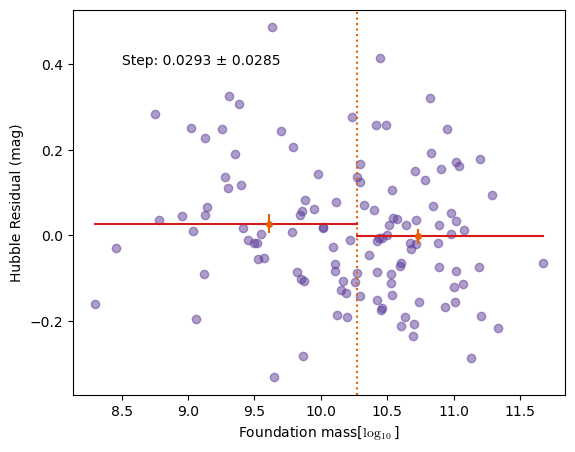

In [363]:
# HR vs M at inner regions
fig = plt.figure(figsize=(8, 5))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
# y1 = [mean_HR1]*100
x1 = np.linspace(np.min(sub1_outer["mass"]),np.max(sub1_outer["mass"]),100)
# y2 = [mean_HR2]*100
x2 = np.linspace(np.min(sub2_outer["mass"]),np.max(sub2_outer["mass"]),100)

# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(outer_region["mass"],outer_region['HR_CLi'], alpha=0.5,color='#5e3c99')
ax_scatter.axvline(median_Mass,linestyle='dotted',color='#e66101',markersize=4)
# ax_scatter.plot([meanM_inner1,meanM_inner2],[meanHR_inner1,meanHR_inner2],
#                 'X',color='#e66101',markersize=10)

ax_scatter.plot(x1,[meanHR_outer1]*100,color='#d7191c',markersize=4)
ax_scatter.plot(x2,[meanHR_outer2]*100,color='#d7191c',markersize=4)
ax_scatter.errorbar([meanM_outer1,meanM_outer2],[meanHR_outer1,meanHR_outer2],
                    yerr=[std_outer1HR,std_outer2HR],fmt='o',color='#e66101',markersize=4)

ax_scatter.set_xlabel('Foundation mass[$\log_{10}$]')
ax_scatter.set_ylabel('Hubble Residual (mag)')
ax_scatter.text(8.5, 0.4, f'Step: {(meanHR_outer1-meanHR_outer2):.4f} ± {(np.sqrt(std_outer1HR**2 + std_outer2HR**2)):.4f}', fontsize=10)
# ax_scatter.axes.set_xlim(0.2, 2.5)
#ax_scatter.axes.set_ylim(-0.7, 0.7)
#ax_scatter.legend()
#ax_scatter.legend(loc='lower right')
plt.savefig('FN_HR vs M_outer.pdf')
plt.show()

In [58]:
print(f'The Hubble residual difference at outer region is: {(meanHR_outer1-meanHR_outer2):.4f}, with uncertainty:{np.sqrt(std_outer1HR**2 + std_outer2HR**2):.4f}')

The Hubble residual difference at outer region is: 0.0281, with uncertainty:0.0315


## Δμ vs dDLR

In [17]:
Host_dDLR = pd.read_csv('Host_dlr.csv')
dDLR = Host_dDLR['d_DLR']

# Merge the dataframes on the "Names" column
Host_dDLR.rename(columns={'CID':'Names'}, inplace=True)
merged_HRdlr = pd.merge(Host_dDLR, FN_HR, on="Names")
selected_HRdlr = merged_HRdlr[(merged_HRdlr['d_DLR'] > 0) & (merged_HRdlr['d_DLR'] <= 4)]

# Split the dataframe into two subsamples at the median of "u-r Color"
#median_dlr = selected_HRdlr["d_DLR"].median()
sub_1 = selected_HRdlr[selected_HRdlr["d_DLR"] <= 1.0]
sub_2 = selected_HRdlr[selected_HRdlr["d_DLR"] > 1.0]

mean_dlr1 = np.mean(sub_1["d_DLR"])
mean_hr1 = np.mean(sub_1["new HR"])

mean_dlr2 = np.mean(sub_2["d_DLR"])
mean_hr2 = np.mean(sub_2["new HR"])

In [ ]:
fig = plt.figure(figsize=(8, 5))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(selected_HRdlr['d_DLR'],selected_HRdlr['new HR'], alpha=0.5,color='#5e3c99')
ax_scatter.axvline(1.0,linestyle='dotted',color='#e66101',markersize=4)
ax_scatter.plot(mean_dlr1,mean_hr1,'X',color='#e66101',markersize=10)
ax_scatter.plot(mean_dlr2,mean_hr2,'X',color='#e66101',markersize=10)
# ax_scatter.plot(leastSfit(mean_dlr1,mean_dlr2,mean_hr1,mean_hr2,selected_HRdlr['d_DLR'])[0], 
#                 leastSfit(mean_dlr1,mean_dlr2,mean_hr1,mean_hr2,selected_HRdlr['d_DLR'])[1], 'b',linestyle='dashed')


ax_scatter.set_xlabel('Relative Separation ($d_{DLR}$)')
ax_scatter.set_ylabel('Hubble Residual (mag)')
# ax_scatter.axes.set_xlim(0.2, 2.5)
# ax_scatter.axes.set_ylim(-0.25, 0.3)
#ax_scatter.legend()
#ax_scatter.legend(loc='lower right')
#plt.savefig('FN HR-dDLR.pdf')
plt.show()

## Δμ vs u-r

In [725]:
Host_color_Vega_reorder = pd.read_csv('Host_color_Vega_reorder.csv')
u_r = Host_color_Vega_reorder['u-r Color']

# Merge the dataframes on the "Names" column
merged_HRur = pd.merge(Host_color_Vega_reorder, FN_HR, on="Names")

# Split the dataframe into two subsamples at the median of "u-r Color"
median_ur = merged_HRur["u-r Color"].median()
sub__1 = merged_HRur[merged_HRur["u-r Color"] <= median_ur]
sub__2 = merged_HRur[merged_HRur["u-r Color"] > median_ur]

mean_ur1 = np.median(sub__1["u-r Color"])
meanHR1 = np.median(sub__1["HR_CLi"])

mean_ur2 = np.median(sub__2["u-r Color"])
meanHR2 = np.median(sub__2["HR_CLi"])
# missing = [7,110,112,115,132,152,169]
# ori_dlr = (pd.read_csv('Host_dlr.csv')).drop(missing)
# ori_dlr.to_csv('Host_dlr.csv',index=True)

In [726]:
from scipy.stats import bootstrap
sub__1M = (np.array(sub__1['u-r Color']), )
res__1M = bootstrap(sub__1M, np.median, confidence_level=0.9,method='percentile')
std__1M = res__1M.standard_error
sub__1HR = (np.array(sub__1['HR_CLi']), )
res__1HR = bootstrap(sub__1HR, np.median, confidence_level=0.9,method='percentile')
std__1HR = res__1HR.standard_error

sub__2M = (np.array(sub__2['u-r Color']), )
res__2M = bootstrap(sub__2M, np.median, confidence_level=0.9,method='percentile')
std__2M = res__2M.standard_error
sub__2HR = (np.array(sub__2['HR_CLi']), )
res__2HR = bootstrap(sub__2HR, np.median, confidence_level=0.9,method='percentile')
std__2HR = res__2HR.standard_error

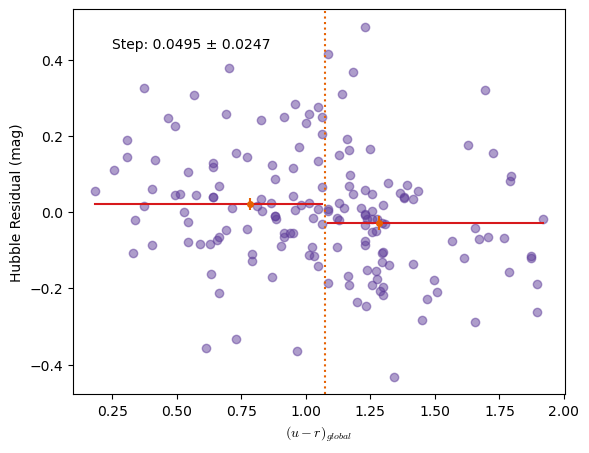

In [728]:
fig = plt.figure(figsize=(8, 5))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
x1 = np.linspace(np.min(sub__1["u-r Color"]),np.max(sub__1["u-r Color"]),100)
# y2 = [mean_HR2]*100
x2 = np.linspace(np.min(sub__2["u-r Color"]),np.max(sub__2["u-r Color"]),100)
# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(merged_HRur['u-r Color'],merged_HRur['HR_CLi'], alpha=0.5,color='#5e3c99')
ax_scatter.axvline(median_ur,linestyle='dotted',color='#e66101',markersize=4)
# ax_scatter.plot(mean_ur1,meanHR1,'X',color='#e66101',markersize=10)
# ax_scatter.plot(mean_ur2,meanHR2,'X',color='#e66101',markersize=10)
# ax_scatter.plot(leastSfit(mean_ur1,mean_ur2,meanHR1,meanHR2,merged_HRur['u-r Color'])[0], 
#                 leastSfit(mean_ur1,mean_ur2,meanHR1,meanHR2,merged_HRur['u-r Color'])[1], 'b',linestyle='dashed')

ax_scatter.plot(x1,[meanHR1]*100,color='#d7191c',markersize=4)
ax_scatter.plot(x2,[meanHR2]*100,color='#d7191c',markersize=4)
ax_scatter.errorbar([mean_ur1,mean_ur2],[meanHR1,meanHR2],
                    yerr=[std__1HR,std__2HR],fmt='o',color='#e66101',markersize=4)

ax_scatter.set_xlabel('$(u-r)_{global}$')
ax_scatter.set_ylabel('Hubble Residual (mag)')
ax_scatter.text(0.25, 0.43, f'Step: {(meanHR1-meanHR2):.4f} ± {(np.sqrt(std__1HR**2 + std__2HR**2)):.4f}', fontsize=10)
# ax_scatter.axes.set_xlim(0.2, 2.5)
# ax_scatter.axes.set_ylim(-0.25, 0.3)
#ax_scatter.legend()
#ax_scatter.legend(loc='lower right')
plt.savefig('FN_HR vs U-R.pdf')
plt.show()

In [367]:
print(f'The color step is: {(meanHR1-meanHR2):.4f}')

The color step is: 0.0663


## Extract mass from the maipenrai

In [573]:
def extract_mass(file_path):
    extracted_elements = []
    # Open the file for reading
    with open(file_path, 'r') as file:
        for i, line in enumerate(file, start=1):
            if (i - 1) % 1 == 0:
                # Split the line into elements
                elements = line.split()
                # Extract the sixth element and append it to the list
                # Ensure there are enough elements to avoid IndexError
                if len(elements) >= 6:
                    extracted_elements.append(elements[5])

    return extracted_elements

In [580]:
REFN_PS1 = extract_mass('results_REFN_PS1.txt_pegase_Kro_test.sav.txt')
len(REFN_PS1)

56

## Label outliers

In [ ]:
FN_Pantheon = pd.read_csv('Foundation_samples.csv')
FN_MASS_Pantheon = list(FN_Pantheon['HOST_LOGMASS'])

FNReMass = pd.read_csv('FN_ReMass.csv') # Foundation sample with re-computed mass
FN_ReMass = list((FNReMass['Mass']))

In [ ]:
def compare_integer_parts(list1, list2):
    indices = []
    for i, (num1, num2) in enumerate(zip(list1, list2)):
        if abs(num1- num2)>0.8:
            indices.append(i)
            corresponding_cid = FN_samples.loc[indices, 'CID']
    return corresponding_cid, indices

In [ ]:
outliers = compare_integer_parts(FN_MASS_Pantheon, FN_ReMass)[0]
out_indices = compare_integer_parts(FN_MASS_Pantheon, FN_ReMass)[1]
#FN_ReMass_rm_outlier = FNReMass[~FNReMass.isin(outliers)]

FN_ReMass_rm_outlier = [value for index, value in enumerate(FN_ReMass) if index not in out_indices]
FN_MASS_P_rm_outlier = [value for index, value in enumerate(FN_MASS_Pantheon) if index not in out_indices]

In [ ]:
distance_outlier = [dist_SN_host1[i-1] for i in out_indices]

max(distance_outlier),max(dist_SN_host1)

(16963292909.64704, 16963292909.64704)

In [ ]:
np.mean(distance_outlier),np.mean(dist_SN_host1_rm_nan)

(2615458874.8851824, 1263139960.00265)

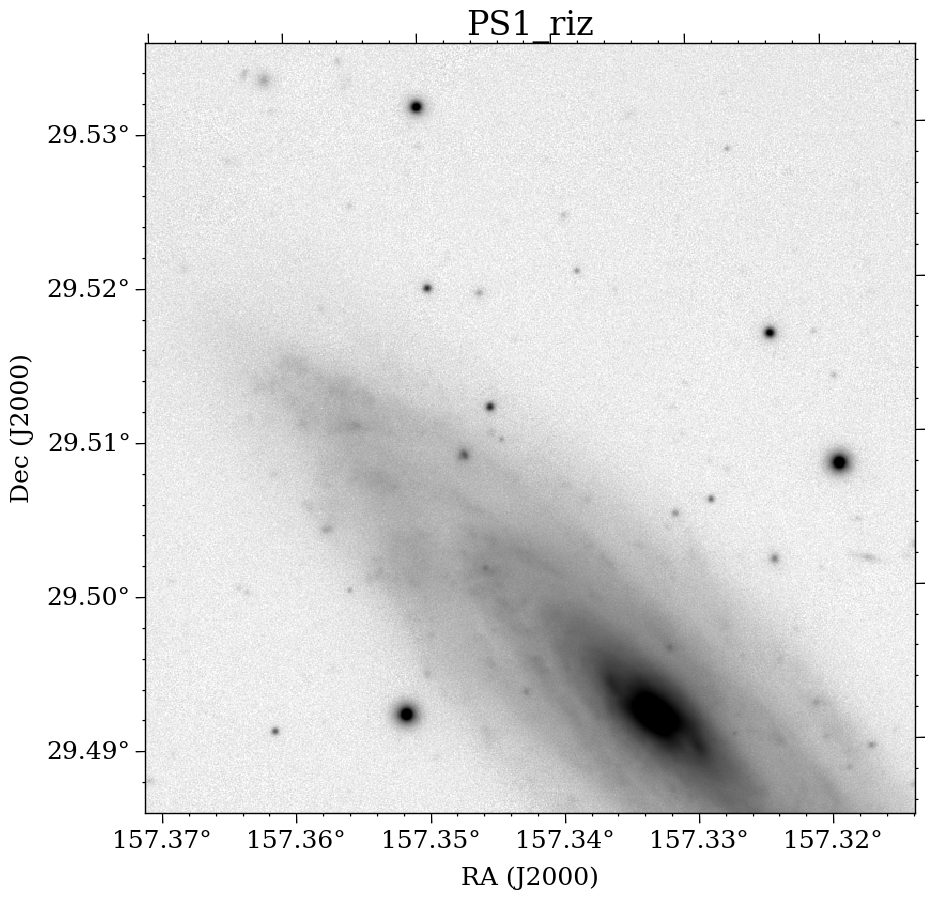

In [145]:
from hostphot.utils import plot_fits

plot_fits('images/2019np/PS1_riz.fits')

## Photometry

In [8]:
surveys = ['PS1','SDSS']
coadd_dict = {'PS1':'riz','SDSS':'riz'} 
# surveys = ['PS1']
# coadd_dict = {'PS1':'riz'} 
phot_type = 'global'
FN_host = pd.read_csv('FN_samples_host_info.csv')
FN_PS1 = pd.read_csv('FN_PS1_ONLY.csv')
FN_PS1SDSS = pd.read_csv('FN_PS1_SDSS.csv')
FN_Host_properties = pd.read_csv('FN_Host_properties.csv')
names = FN_host['CID']
ras = FN_host['RA']
decs = FN_host['DEC']
host_ras = FN_host['HOST_RA']
host_decs = FN_host['HOST_DEC']
redshifts = FN_host['zHD']

# 29,31, 59, 63, 67
# ASASSN-16dn, AT2016bln


In [15]:
# n = 0
# name     =      names[n]
# ra       =        ras[n]
# dec      =       decs[n]
# host_ra  =   host_ras[n]
# host_dec =  host_decs[n]
# z        =  redshifts[n]

n = 0
name     =      FN_Host_properties['Names'][n]
ra       =        FN_Host_properties['SN_RA'][n]
dec      =       FN_Host_properties['SN_DEC'][n]
host_ra  =   182.02431	
host_dec =  65.17431
z        =  FN_Host_properties['Redshift'][n]

name, z, ra, dec, host_ra, host_dec

('SN2016coj', 0.0057, 182.028, 65.1772, 182.02431, 65.17431)

In [16]:
if name in FN_PS1SDSS['CID']:
    surveys = ['PS1','SDSS']
    coadd_dict = {'PS1':'riz','SDSS':'riz'} 
elif name in FN_PS1['CID']:
    surveys = ['PS1'] 
    coadd_dict = {'PS1':'riz'} 
surveys

['PS1', 'SDSS']

In [ ]:
for survey in surveys:
    download_images(name,ra,dec, survey=survey,size=6, overwrite=True)

In [187]:
surveys = ['PS1'] 
coadd_dict = {'PS1':'riz'}
for survey, coadd_filters in coadd_dict.items():
    coadd_images(name, filters=coadd_filters, survey=survey)

In [191]:
coadd_mask_params = create_mask(name,host_ra,host_dec,
                                filt='riz', survey= 'PS1',
                                extract_params=True, crossmatch=True,
                                threshold=18)

In [47]:
sigma_dict = {survey:8 if survey!='GALEX' else 4 for survey in surveys}
for survey, coadd_filters in coadd_dict.items():
    filters = get_survey_filters(survey)
    for filt in filters:
        create_mask(name, host_ra, host_dec,
                filt, survey=survey,
                common_params=coadd_mask_params,
                sigma=sigma_dict[survey])

In [22]:
survey = 'PS1'
coadd_filters = 'riz'
eps = 0.0005
aperture_params = gp.extract_kronparams(name, host_ra, host_dec,
                                        coadd_filters, survey,
                                        ra=ra, dec=dec, use_mask=True,
                                        optimize_kronrad=True, eps=eps,
                                        save_plots=True,
                                        save_aperture_params=True,threshold=265)

In [23]:
print(name,':(',aperture_params[0]['a'][0], 
      aperture_params[0]['b'][0], aperture_params[0]['theta'][0],')')

SN2016coj :( 18.094768524169922 10.938899993896484 -0.09344460815191269 )


In [58]:
print('PS16cvc:',(1.743251085281372, 0.8751553893089294, -0.5799084901809692))
print('PSNJ0252467:',(4.806911945343018, 4.107807159423828, 0.4166851341724396))
print('ASASSN-15mf:',(0.9657313823699951, 0.7717933058738708, -1.5688731670379639))
print('AT2016eoa:',(10.604339599609375, 9.72329902648925, 0.3264637291431427))
print('PSNJ1602512:',(8.668859481811523, 4.736493110656738, -0.20935186743736267))
print('ASASSN-15mf:',(1.1999950408935547, 0.9926469326019287, -0.00589695805683732))

PS16cvc: (1.743251085281372, 0.8751553893089294, -0.5799084901809692)
PSNJ0252467: (4.806911945343018, 4.107807159423828, 0.4166851341724396)
ASASSN-15mf: (0.9657313823699951, 0.7717933058738708, -1.5688731670379639)
AT2016eoa: (10.604339599609375, 9.72329902648925, 0.3264637291431427)
PSNJ1602512: (8.668859481811523, 4.736493110656738, -0.20935186743736267)
ASASSN-15mf: (1.1999950408935547, 0.9926469326019287, -0.00589695805683732)


In [ ]:
#coadd_dict = {'PS1':'riz'}
for survey in surveys:
        gp.multi_band_phot(name, host_ra, host_dec,
                survey=survey, ra=ra, dec=dec,
                use_mask=True, correct_extinction=True,
                aperture_params=aperture_params,
                save_plots=True, save_results=True,
                raise_exception=True)
                
plot_sed(name, phot_type, z=z)

In [6]:
def global_phot(name,z, ra,dec,host_ra,host_dec):
        surveys = ['PS1','SDSS']
        coadd_dict = {'PS1':'riz','SDSS':'riz'} 
        phot_type = 'global'
        
        for survey in surveys:
                download_images(name,ra,dec, survey=survey, overwrite=True)

        for survey, coadd_filters in coadd_dict.items():
                coadd_images(name, filters=coadd_filters, survey=survey)

        survey = 'PS1'
        filters = get_survey_filters(survey)
        coadd_filters = coadd_dict[survey]
        coadd_mask_params = create_mask(name, host_ra, host_dec,
                                        filt='riz', survey=survey,
                                        extract_params=True,threshold=3)
        sigma_dict = {survey:8 if survey!='GALEX' else 4 for survey in surveys}
        for survey, coadd_filters in coadd_dict.items():
                filters = get_survey_filters(survey)
                for filt in filters:
                        create_mask(name, host_ra, host_dec,
                                filt, survey=survey,
                                common_params=coadd_mask_params,
                                sigma=sigma_dict[survey])
                
                
        survey = 'PS1'
        coadd_filters = 'riz'
        eps = 0.0005
        aperture_params = gp.extract_kronparams(name, host_ra, host_dec,
                                                coadd_filters, survey,
                                                ra=ra, dec=dec, use_mask=True,
                                                optimize_kronrad=True, eps=eps,
                                                save_plots=True,
                                                save_aperture_params=True,threshold=3)

        coadd_dict = {'PS1':'riz'}
        for survey in surveys:
                gp.multi_band_phot(name, host_ra, host_dec,
                        survey=survey, ra=ra, dec=dec,
                        use_mask=True, correct_extinction=True,
                        aperture_params=aperture_params,
                        save_plots=True, save_results=True,
                        raise_exception=True)
                
        plot_sed(name, phot_type, z=z)
        return aperture_params

In [230]:
#FN_host = pd.read_csv('Foundation_samples_host_info.csv')
names = FN_Host_properties['Names']
ras = FN_Host_properties['SN_RA']
decs = FN_Host_properties['SN_DEC']
host_ras = FN_Host_properties['HOST_RA']
host_decs = FN_Host_properties['HOST_DEC']
redshiftss = FN_Host_properties['Redshift']
FN_shape_low_threshold2 = []
n = 29
while n < len(FN_Host_properties):
    survey = 'PS1'
    coadd_filters = 'riz'
    eps = 0.0005
    name     =      names[n]
    ra       =        ras[n]
    dec      =       decs[n]
    host_ra  =   host_ras[n]
    host_dec =  host_decs[n]
    z        = redshiftss[n]

    params = gp.extract_kronparams(name, host_ra, host_dec,
                                        coadd_filters, survey,
                                        ra=ra, dec=dec, use_mask=True,
                                        optimize_kronrad=True, eps=eps,
                                        save_plots=True,
                                        save_aperture_params=True,threshold=1.5)
    FN_shape_low_threshold2.append([name,params[0]['a'][0],params[0]['b'][0],params[0]['theta'][0]])
    n+=1

In [231]:
FN_shape_low_threshold2 = pd.DataFrame(FN_shape_low_threshold2, columns=['Names','a','b','theta'])
FN_shape_low_threshold2.to_csv('FN_shape_low_threshold2.csv',index=False)

In [208]:
names[28]

'PSNJ1602512'

# Aladin

In [751]:
Aladin_shape_deg = pd.read_csv('Aladin_FN_shape_deg.csv')
Aladin_xSN = Aladin_shape_deg['SN_RA']
Aladin_ySN = Aladin_shape_deg['SN_DEC']

Aladin_xHOST = Aladin_shape_deg['HOST_RA']
Aladin_yHOST = Aladin_shape_deg['HOST_DEC']

Aladin_a = Aladin_shape_deg['A']
Aladin_b = Aladin_shape_deg['B']
Aladin_theta = Aladin_shape_deg['Theta']
# [8,114,116,119,138,158,178]

In [741]:
SN_RA = []
SN_DEC = []
for i in range(len(Aladin_shape_deg)):
    CID = Aladin_shape_deg['CID'][i]
    if CID in list(FN_host['CID']):
        SN_RA.append(FN_host.loc[FN_host['CID'] == CID, 'RA'].values[0])
        SN_DEC.append(FN_host.loc[FN_host['CID'] == CID, 'DEC'].values[0])

Aladin_shape_deg['SN_RA'] = SN_RA
Aladin_shape_deg['SN_DEC'] = SN_DEC
Aladin_shape_deg.to_csv('Aladin_FN_shape_deg.csv',index=False)

In [766]:
### angular separation between SN and host using formular ###
Aladin_angsep = []
for i in range(len(Aladin_xSN)):
    Aladin_ang_deg = (np.sqrt((Aladin_xSN[i]-Aladin_xHOST[i])**2 + (Aladin_ySN[i]-Aladin_yHOST[i])**2))
    Aladin_ang_arcsec = Aladin_ang_deg*(u.deg).to(u.arcsec)
    Aladin_angsep.append(Aladin_ang_arcsec)

In [767]:
### DLR ###
Aladin_DLR = []
for i in range(len(Aladin_a)):
    Aladin_a_arcsec = (Aladin_a[i]*(u.deg)).to(u.arcsec)
    Aladin_b_arcsec = (Aladin_b[i]*(u.deg)).to(u.arcsec)
    DLR = (Aladin_a_arcsec*Aladin_b_arcsec)/(np.sqrt((Aladin_a_arcsec*np.sin(Aladin_theta[i]*(u.deg)))**2 + (Aladin_b_arcsec*np.cos(Aladin_theta[i]*(u.deg)))**2))
    Aladin_DLR.append(DLR.value)

In [768]:
### dDLR ###
Aladin_dDLR = []
for i in range(len(Aladin_a)):
    Aladin_dDLR.append(Aladin_angsep[i]/Aladin_DLR[i])

In [802]:
### Filtered out the SNe with dDLR > 4 ###
Aladin_dDLR = np.array(Aladin_dDLR)
Aladin_DLR = np.array(Aladin_DLR)
Aladin_dDLR_filtered = Aladin_dDLR[(Aladin_dDLR >0) & (Aladin_dDLR <= 4)]
Aladin_DLR_filtered = Aladin_DLR[(Aladin_DLR >0) & (Aladin_DLR <= 4)]
np.mean(Aladin_dDLR_filtered),np.median(Aladin_dDLR_filtered), len(Aladin_dDLR_filtered)

(1.6268309978200337, 1.4069217400598433, 134)

(array([10.,  6.,  9., 13., 13., 12.,  8.,  8., 11.,  4.,  6.,  0.,  2.,
         8.,  6.,  5.,  3.,  3.,  2.,  5.]),
 array([0.11322052, 0.30678777, 0.50035503, 0.69392229, 0.88748955,
        1.08105681, 1.27462407, 1.46819133, 1.66175859, 1.85532584,
        2.0488931 , 2.24246036, 2.43602762, 2.62959488, 2.82316214,
        3.0167294 , 3.21029666, 3.40386391, 3.59743117, 3.79099843,
        3.98456569]),
 <BarContainer object of 20 artists>)

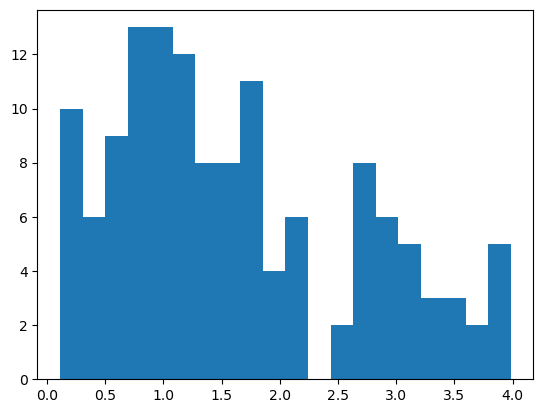

In [815]:
plt.hist(Aladin_dDLR_filtered,bins=20)

# Shape Parameters

In [15]:
FN_Host_properties = pd.read_csv('FN_Host_properties.csv')
FN_z = []
FN_ras = []
FN_decs = []
FN_host_ras = []
FN_host_decs = []
for i in range(len(FN_Host_properties)):
    CID = FN_Host_properties['Names'][i]
    if CID in list(FN_host['CID']):
        FN_z.append(FN_host.loc[FN_host['CID'] == CID, 'zHD'].values[0])
        FN_ras.append(FN_host.loc[FN_host['CID'] == CID, 'RA'].values[0])
        FN_decs.append(FN_host.loc[FN_host['CID'] == CID, 'DEC'].values[0])
        FN_host_ras.append(FN_host.loc[FN_host['CID'] == CID, 'HOST_RA'].values[0])
        FN_host_decs.append(FN_host.loc[FN_host['CID'] == CID, 'HOST_DEC'].values[0])

In [94]:
FN_Host_properties['Redshift'] = FN_z
FN_Host_properties['SN_RA'] = FN_ras
FN_Host_properties['SN_DEC'] = FN_decs
FN_Host_properties['HOST_RA'] = FN_host_ras
FN_Host_properties['HOST_DEC'] = FN_host_decs
FN_Host_properties.to_csv('FN_Host_properties.csv',index=False)

In [98]:
FN_Host_properties

,Unnamed: 0,Names,Redshift,SN_RA,SN_DEC,HOST_RA,HOST_DEC,LOGMASS,U-R Color,HR,HR_err
0,0,SN2016coj,0.00570,182.0280,65.1772,-999.000000,-999.000000,10.769,1.298282,0.019315,0.483672
1,1,2018gv,0.00602,121.3940,-11.4379,121.408500,-11.427030,10.094,1.295473,-0.027013,0.350271
2,2,2019np,0.00648,157.3420,29.5106,157.333080,29.491830,10.231,1.048933,0.275647,0.322304
3,3,2017erp,0.00677,227.3120,-11.3342,227.317040,-11.321670,10.166,1.295473,-0.106493,0.371159
4,4,ASASSN-15so,0.00857,168.5460,48.3187,168.545385,48.318615,10.632,1.048933,0.007428,0.267587
...,...,...,...,...,...,...,...,...,...,...,...
159,159,AT2016gsu,0.07575,17.1024,21.1516,17.102210,21.151810,10.087,0.712069,0.010915,0.217318
160,160,Gaia16acv,0.07859,179.9570,54.8022,179.957521,54.801986,9.023,0.913563,0.251538,0.146133
161,161,PS15bzz,0.07931,9.4247,1.7628,9.423138,1.767180,10.607,0.664848,-0.211416,0.147231
162,162,SN2016glp,0.08410,354.0580,23.6960,354.058190,23.695907,10.241,0.339259,-0.019114,0.221777


In [96]:
def extract_objects(data, bkg, host_ra, host_dec, threshold, img_wcs, dist_thresh):
    """Extracts objects and their ellipse parameters. The function :func:`sep.extract()`
    is used.

    If there is no detected object within a distance of ``dist_thresh`` from the galaxy
    coordinates, it means that the galaxy was not correctly identified.

    Parameters
    ----------
    data: ndarray
        Image data.
    bkg: 2D array
        Background level of the image.
    host_ra: float
        Host-galaxy Right ascension of the galaxy in degrees.
    host_dec: float
        Host-galaxy Declination of the galaxy in degrees.
    threshold: float
        Source with flux above ``threshold*bkg_rms`` are extracted.
        See :func:`sep.extract()` for more information.
    img_wcs: WCS
        Image's WCS.
    pixel_scale: float
        Pixel scale, in units of arcsec/pixel, used to convert from pixel units
        to arcseconds.
    dist_thresh: float, default ``-1``.
        Distance in arcsec to crossmatch the galaxy coordinates with a detected object,
        where the object nearest to the galaxy position is considered as the galaxy (within
        the given threshold). If no objects are found within the given distance threshold,
        the galaxy is considered as not found and a warning is printed. If a non-positive value
        is given, the threshold is considered as infinite, i.e. the closest detected object is
        considered as the galaxy (default option).

    Returns
    -------
    gal_obj: numpy array
        Galaxy object extracted.
    nogal_objs: numpy array
        All objects extracted except for the galaxy.
    """
    # extract objects with Source Extractor
    objects = sep.extract(data, threshold, err=bkg)

    host_coords = SkyCoord(ra=host_ra, dec=host_dec, unit=(u.degree, u.degree), frame="icrs")
    
    objs_coords = img_wcs.pixel_to_world(objects["x"], objects["y"])
    distances = host_coords.separation(objs_coords).to(u.arcsec)
    dist_arcsec = distances.value

    if dist_thresh <= 0.0:
        dist_thresh = np.inf

    if any(dist_arcsec <= dist_thresh):
        gal_id = np.argmin(dist_arcsec)
        gal_obj = objects[gal_id : gal_id + 1]
    else:
        gal_obj = None
        gal_id = -99
        print("WARNING: the galaxy was no detected")

    objs_id = [i for i in range(len(objects)) if i != gal_id]
    nogal_objs = objects.take(objs_id)

    return gal_obj

In [101]:
FN_Host_properties = pd.read_csv('FN_Host_Properties.csv')
survey = 'PS1'
filt = 'riz'
FN_shapeparams_lowthreshold = []
i = 1
while i < len(FN_Host_properties):
    obj_dir = os.path.join(workdir, FN_Host_properties['Names'][i])
    obj_fits = os.path.join(obj_dir, f"{survey}_{filt}.fits")
    data = remove_nan(fits.open(obj_fits))[0].data
    bkg = sep.Background(data.astype(np.float64))
    bkg_rms = bkg.rms()
    data_sub = np.copy(data-bkg)
    img_wcs = AsWCS.WCS(fitsio.read_header(obj_fits), naxis=2)
    host_ra = FN_Host_properties['HOST_RA'][i]
    host_dec = FN_Host_properties['HOST_DEC'][i]
    sn_ra = FN_Host_properties['SN_RA'][i]
    sn_dec = FN_Host_properties['SN_DEC'][i]
    gal_obj = extract_objects(data_sub, bkg_rms, host_ra, host_dec, 1.5, img_wcs, dist_thresh=40)
    a = gal_obj['a'][0]
    b = gal_obj['b'][0]
    theta = gal_obj['theta'][0]
    FN_shapeparams_lowthreshold.append([ FN_Host_properties['Names'][i],a,b,theta])
    i += 1
#shapeparams1 = pd.DataFrame(DEBASS_shapeparams, columns=['snid','a','b','theta'])

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]

In [102]:
FN_shapeparams_lowthreshold = pd.DataFrame(FN_shapeparams_lowthreshold, columns=['Names','a','b','theta'])
FN_shapeparams_lowthreshold.to_csv('FN_shapeparams_lowthreshold.csv',index=False)

# Edit Image - Add a line that represents 1kpc

In [348]:
cosmo =  FlatLambdaCDM(H0=73.04, Om0=0.326)
DA1 = (((cosmo.comoving_distance(0.01995)).to(u.pc))*(1+0.01995)).to(u.kpc)
theta1 = (5*(u.kpc)/DA1)*(u.rad).to(u.arcsec)

DA2 = (((cosmo.comoving_distance(0.02052)).to(u.pc))*(1+0.02052)).to(u.kpc)
theta2 = (5*(u.kpc)/DA2)*(u.rad).to(u.arcsec)

print('The angular size of 1 kpc at z=0.01995 is:',theta1,'deg')
print('The angular size of 1 kpc at z=0.02052 is:',theta2,'deg')

The angular size of 1 kpc at z=0.01995 is: 12.409215017747238 deg
The angular size of 1 kpc at z=0.02052 is: 12.059476626111898 deg


In [349]:
theta2/pixel_scale_PS1,theta1/pixel_scale_PS1

(<Quantity 48.23790534 1 / arcsec>, <Quantity 49.63685887 1 / arcsec>)

In [36]:
from PIL import Image, ImageDraw, ImageFont

# Load the image /Users/dingyuancao/Desktop/RSAA-Summer/Data-Analysing/images/2016W
image_path = '/Users/dingyuancao/Desktop/RSAA-Summer/Data-Analysing/images/2016W/global_PS1_riz.jpg'
image = Image.open(image_path)

# Create a drawing context
draw = ImageDraw.Draw(image)

# Define the position and length of the bar
# Position it at the bottom left with some margin
x_start = 183
y_start = image.height - 150
x_end = x_start + int(49.63685887 )  # length of the bar in pixels
y_end = y_start

# Define color and width of the line
line_color = 'blue'
line_width = 3

# Draw the line
draw.line([x_start, y_start, x_end, y_end], fill=line_color, width=line_width)

# Optionally, add text to indicate the bar represents 1 kpc
font = ImageFont.load_default(size=30)
draw.text((x_start, y_start + 10), '5 kpc',font=font, fill=line_color)

# Save the modified image
output_path = '/Users/dingyuancao/Desktop/RSAA-Summer/Data-Analysing/2016W_edited.jpg'
image.save(output_path,dpi=(300,300))
output_path


'/Users/dingyuancao/Desktop/RSAA-Summer/Data-Analysing/2016W_edited.jpg'

In [37]:
from PIL import Image, ImageDraw

# Load the image /Users/dingyuancao/Desktop/RSAA-Summer/Data-Analysing/images/2016W
image_path = '/Users/dingyuancao/Desktop/RSAA-Summer/Data-Analysing/images/PSNJ1602512/global_PS1_g.jpg'
image = Image.open(image_path)

# Create a drawing context
draw = ImageDraw.Draw(image)

# Define the position and length of the bar
# Position it at the bottom left with some margin
x_start = 750
y_start = image.height - 730
x_end = x_start + int(48.23790534)  # length of the bar in pixels
y_end = y_start

# Define color and width of the line
line_color = 'blue'
line_width = 3

# Draw the line
draw.line([x_start, y_start, x_end, y_end], fill=line_color, width=line_width)

# Optionally, add text to indicate the bar represents 1 kpc
font = ImageFont.load_default(size=30)

draw.text((x_start, y_start + 10), '5 kpc',font = font, fill=line_color)

# Save the modified image
output_path = '/Users/dingyuancao/Desktop/RSAA-Summer/Data-Analysing/PSNJ1602512_edited.jpg'
image.save(output_path)
output_path


'/Users/dingyuancao/Desktop/RSAA-Summer/Data-Analysing/PSNJ1602512_edited.jpg'